In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Lasso


import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.nn import sigmoid

In [2]:
# from jax.config import config; config.update("jax_enable_x64", True)

In [3]:
EPS = 1e-10
fontsize=13

# Testing

In [4]:
import sys
sys.path.append('../')
import adaprobe

In [5]:
N = 256
K = 2000
powers = np.arange(20, 51, 10)
phi_1 = np.random.uniform(2.5, 5.5, N)
a = 0.25
sigma = 1

sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)

In [6]:
num_targets = 8

In [7]:
# sim.simulate(trials=K, powers=powers)
sim.simulate_multistim(trials=K, num_targets=num_targets, powers=powers)

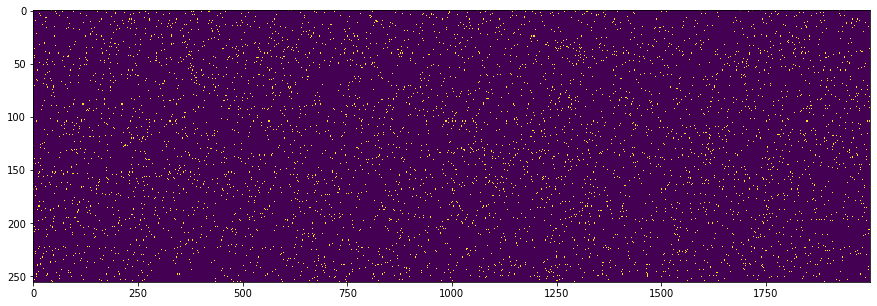

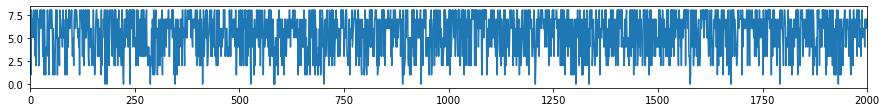

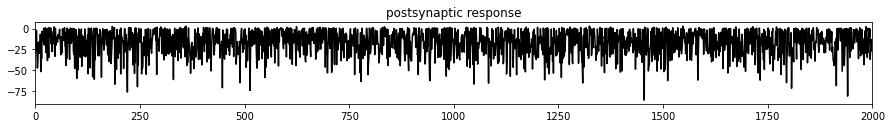

In [8]:
plt.figure(figsize=(15, 5))
plt.imshow(sim.spks, aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(15, 1.5))
plt.plot(np.sum(sim.spks, 0))
plt.xlim([0, K])
plt.show()

plt.figure(figsize=(15, 1.5))
plt.title('postsynaptic response')
plt.plot(sim.y, color='k')
plt.xlim([0, K])
plt.show()

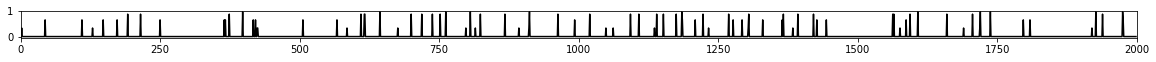

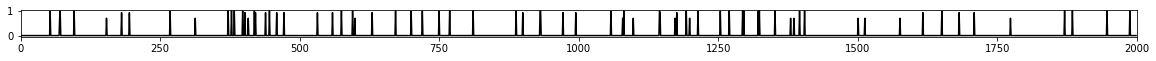

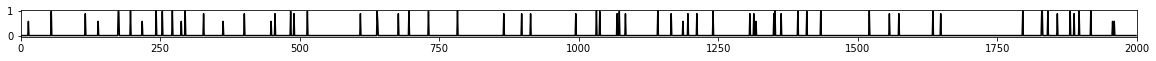

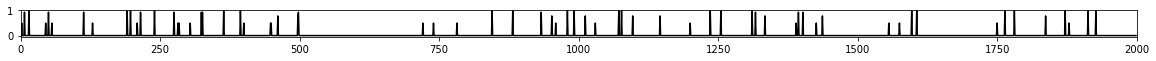

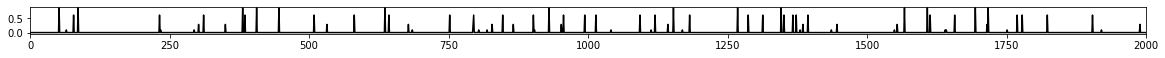

In [9]:
for n in range(5):
    plt.figure(figsize=(20, 0.5))
    plt.plot(sim.fr[n], color='k')
    plt.xlim([0, K])
    plt.show()

In [10]:
stim = np.zeros((N, K))
for n in range(N):
    locs = np.where(sim.tars == n)[0]
    stim[n, locs] = sim.I[locs]

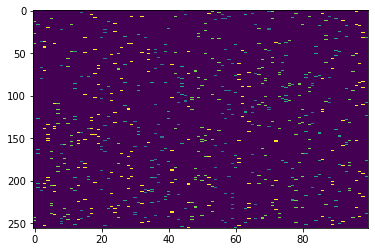

In [11]:
plt.imshow(stim[:, :100], aspect='auto', interpolation='nearest')

In [12]:
# init_mu = np.zeros(N)
# for n in range(N):
#     resp = sim.y[np.where(sim.tars == n)[0]].reshape(-1, 1)
#     init_mu[n] = np.min(GaussianMixture(n_components=2, covariance_type='full').fit(resp).means_)

In [13]:
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])

In [15]:
fit_options = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 1e-4
}

priors = {
    'alpha': 0.15 * np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

model = adaprobe.Model(sim.cell_locs, priors=priors)

In [16]:
# from adaprobe.optimise.cavi_offline_spike_and_slab_NOTS_jax import update_alpha

# update_alpha()

In [17]:
# update_alpha(sim.y, model.state['mu'], model.state['beta'], 1 * np.ones(N), jnp.array(model.state['lam']).T, model.state['shape'], model.state['rate'], model.priors['alpha'], model.n_presynaptic)

# # lam = np.array(m['lam']).T

# # plt.imshow(lam, aspect='auto')

# # plt.plot(lam[0])

# # np.round(model.state['alpha'], 3)

# # np.round(model.state['mu'], 3)

In [18]:
# update_alpha(sim.y, model.state['beta'], 1 * np.ones(N), jnp.array(model.state['lam']).T, model.state['shape'], model.state['rate'], model.priors['alpha'], model.n_presynaptic)


In [19]:
model.reset()

In [20]:
%time model.fit(sim.y, stim, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188775.15625, tolerance: 91.1082763671875
  model = cd_fast.enet_coordinate_descent(


CPU times: user 2min 58s, sys: 2min 41s, total: 5min 40s
Wall time: 31.5 s


In [21]:
mu_hist = model.history['mu'].T
alpha_hist = model.history['alpha'].T
w_hist = mu_hist * alpha_hist

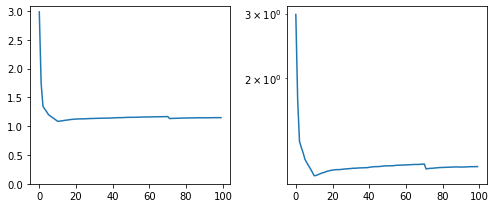

In [22]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(np.mean(np.abs(w_hist - sim.w[:, None]), 0))
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(np.mean(np.abs(w_hist - sim.w[:, None]), 0))
# plt.ylim(bottom=0)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [23]:
# model.reset()

In [24]:
# model.fit(np.array(sim.y), stim_online, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

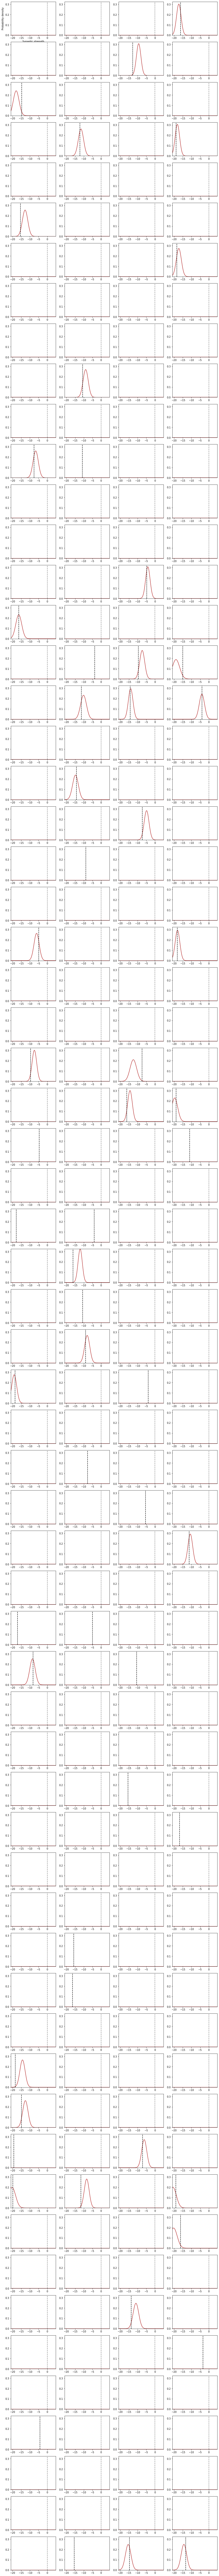

In [25]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, sim, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(model, sim)

In [26]:
model.state['mu']

DeviceArray([ 4.27679688e-01, -1.87121439e+00, -3.21757793e+00,
             -1.73173409e+01,  2.40049064e-01, -7.69554257e-01,
             -9.40303993e+00, -9.05512273e-01, -1.79422550e+01,
             -1.02059376e+00,  1.78748715e+00,  1.10676658e+00,
              2.16484115e-01, -1.16308289e+01,  1.28068316e+00,
             -1.81349182e+01, -1.33089066e+00,  1.59398559e-02,
              1.98899472e+00,  9.24415052e-01, -1.28003416e+01,
              8.86118293e-01, -3.63564432e-01,  4.40319002e-01,
              2.83109879e+00, -3.19110930e-01,  2.14127302e+00,
             -1.73095341e+01,  9.60013092e-01,  2.62674117e+00,
             -1.04419363e+00, -7.54899681e-01, -1.13903904e+00,
              5.39271355e-01,  1.65385768e-01,  1.79498994e+00,
             -5.90240598e-01, -8.92130470e+00,  1.71560681e+00,
              1.05182409e+00,  1.06713271e+00,  8.92999530e-01,
              5.46061563e+00,  9.67377722e-01, -6.67858171e+00,
             -1.86429195e+01,  1.2986686

In [27]:
model.state['beta']

DeviceArray([ 9.999986 ,  9.999917 ,  9.999601 ,  1.3210689,  9.999994 ,
              9.999993 ,  1.2937695,  9.999916 ,  1.6533409,  9.99999  ,
             10.       ,  9.999998 , 10.       ,  1.5260217, 10.       ,
              1.3034714,  9.999983 ,  9.99999  , 10.       , 10.       ,
              1.5614374,  9.999945 ,  9.999995 ,  9.999936 ,  9.999996 ,
              9.999997 , 10.       ,  1.4596592, 10.       ,  9.999997 ,
             10.       ,  9.999991 ,  9.99996  , 10.       ,  9.999986 ,
              9.999966 , 10.       ,  1.4809093, 10.       , 10.       ,
              9.999997 , 10.       ,  9.999925 ,  9.99978  ,  1.5296555,
             10.       , 10.       ,  9.999999 ,  9.999995 , 10.       ,
             10.       , 10.       ,  9.999992 ,  9.999962 ,  9.999999 ,
              9.99999  , 10.       ,  9.999973 ,  1.2950803,  9.999999 ,
              1.7114547,  9.999996 ,  9.9999895,  9.999993 ,  9.999999 ,
              9.999877 ,  1.4405332,  2.116966 ,  9

In [28]:
model.state['alpha']

DeviceArray([1.0122974e-07, 5.9978811e-07, 3.0895710e-06, 1.0000000e+00,
             4.5393708e-08, 4.0198270e-08, 1.0000000e+00, 6.8667350e-07,
             1.0000000e+00, 6.8943073e-08, 9.8612264e-11, 1.1340131e-08,
             6.5458548e-11, 1.0000000e+00, 2.4001046e-09, 1.0000000e+00,
             1.2065054e-07, 6.1276921e-08, 2.1556024e-11, 2.5049944e-09,
             1.0000000e+00, 4.1110243e-07, 2.6828484e-08, 5.0132343e-07,
             3.1559985e-08, 1.8274930e-08, 1.0073935e-11, 1.0000000e+00,
             1.3225014e-09, 2.5414609e-08, 2.6359212e-11, 5.5272782e-08,
             3.2477340e-07, 8.7913943e-10, 1.2301291e-07, 2.6660715e-07,
             2.8057336e-09, 1.0000000e+00, 9.0210638e-11, 1.5277862e-09,
             1.4912292e-08, 2.3124973e-10, 1.0237296e-06, 2.0886650e-06,
             9.9999642e-01, 2.3587596e-10, 4.4588456e-12, 1.0700066e-08,
             3.7786698e-08, 9.0433599e-10, 7.2108891e-10, 4.1156410e-12,
             4.6057931e-08, 2.5924624e-07, 5.589848

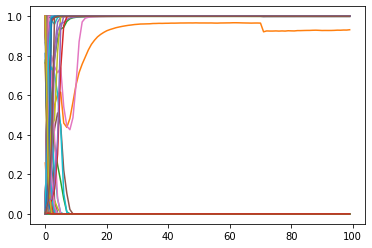

In [29]:
plt.plot(model.history['alpha'])
plt.show()

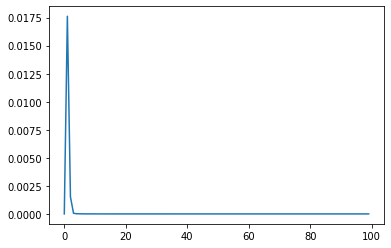

In [30]:
plt.plot(model.history['alpha'].T[7])

In [31]:
np.round(model.state['alpha'], 2)

DeviceArray([0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 1.  , 0.  ,
             0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
             1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
             0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
             0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
             0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ,
             1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 0.  , 1.  ,
             1.  , 0.93, 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
             0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
             0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
             0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 0.  , 0.  , 0.  ,
             1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
             0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
             0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.

In [32]:
print(np.round(model.state['mu'], 2))
print(np.round(sim.w, 2))

[ 4.2999998e-01 -1.8700000e+00 -3.2200000e+00 -1.7320000e+01
  2.3999999e-01 -7.6999998e-01 -9.3999996e+00 -9.0999997e-01
 -1.7940001e+01 -1.0200000e+00  1.7900000e+00  1.1100000e+00
  2.2000000e-01 -1.1630000e+01  1.2800000e+00 -1.8129999e+01
 -1.3299999e+00  2.0000000e-02  1.9900000e+00  9.1999996e-01
 -1.2799999e+01  8.8999999e-01 -3.5999998e-01  4.4000000e-01
  2.8299999e+00 -3.1999999e-01  2.1399999e+00 -1.7309999e+01
  9.5999998e-01  2.6299999e+00 -1.0400000e+00 -7.5000000e-01
 -1.1400000e+00  5.3999996e-01  1.7000000e-01  1.7900000e+00
 -5.8999997e-01 -8.9200001e+00  1.7199999e+00  1.0500000e+00
  1.0699999e+00  8.8999999e-01  5.4600000e+00  9.6999997e-01
 -6.6799998e+00 -1.8639999e+01  1.3000000e+00  1.4000000e+00
  8.3999997e-01  1.5400000e+00 -6.4999998e-01  1.7500000e+00
 -7.6999998e-01  1.9799999e+00  1.5300000e+00 -1.8499999e+00
  5.2199998e+00 -1.9599999e+00 -4.1100001e+00 -7.5000000e-01
 -1.6459999e+01  1.8099999e+00  1.5799999e+00  1.7199999e+00
 -1.6899999e+00 -6.07999

In [33]:
def plot_spike_pred(model, sim, xlim=None):
#     spks = np.array(sim.spks).astype(float) # true simulated spikes
#     fr = np.array(sim.fr).T # true simulated firing rates
    lam = np.array(model.state['lam']).T # inferred firing rate
    spks = sim.spks
    fr = sim.fr
    print(spks.shape)
    s_pred = (lam >= 0.5).astype(float) # spike prediction
    for n in range(N):
        plt.figure(figsize=(25, 0.75))
        if sim.w[n] == 0:
            plt.plot(fr[n], color='gray') # disconnected cell
        else:
            plt.plot(fr[n], color='k') # connected cell
        plt.plot(lam[n], '--', color='r')
        plt.scatter(np.arange(len(spks[n])), spks[n], color='gray')
        plt.scatter(np.arange(s_pred[0].shape[0]), s_pred[n], 50, marker='x', color='r')
        if xlim is not None:
            plt.xlim(xlim)
        else:
            plt.xlim([0, lam.shape[-1]])
        plt.ylim([0, 1.1])
        plt.show()

(256, 2000)


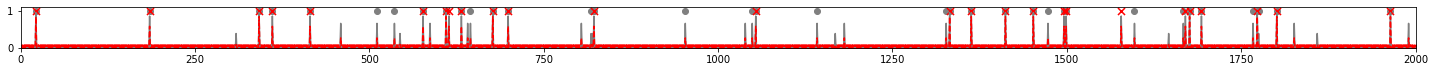

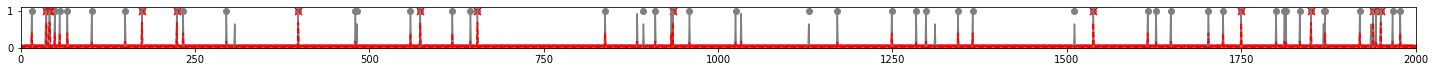

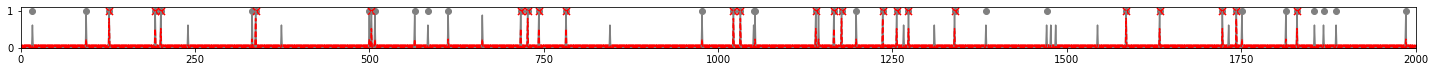

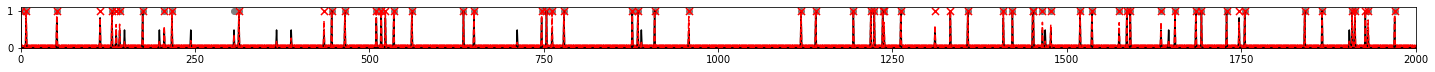

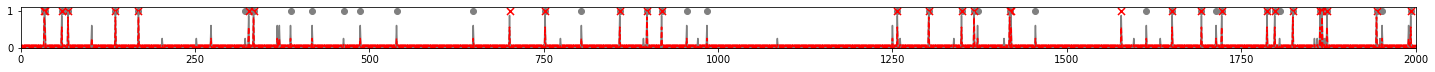

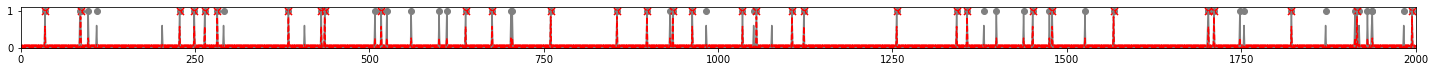

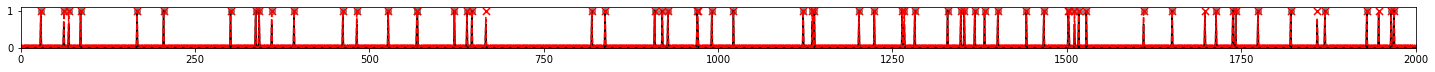

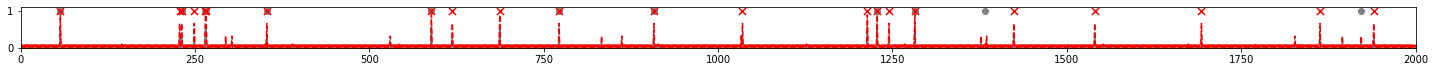

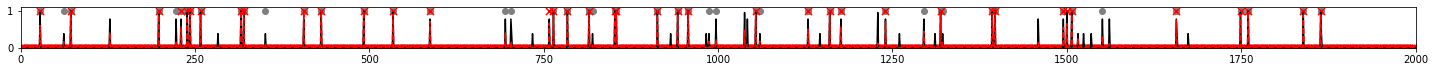

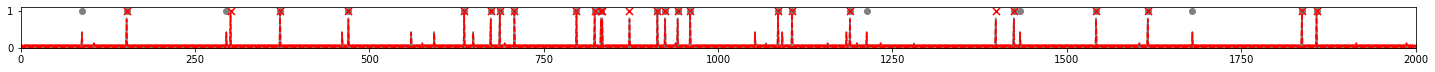

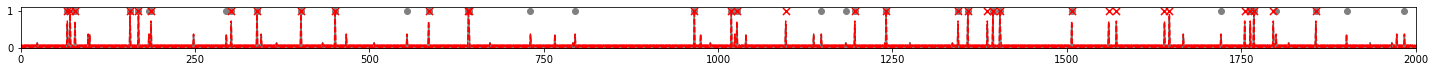

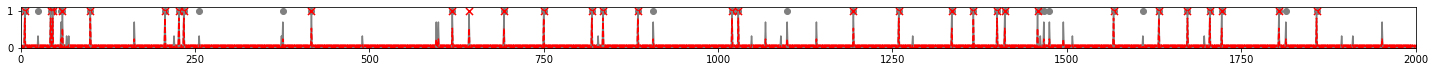

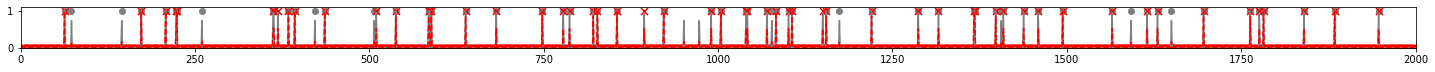

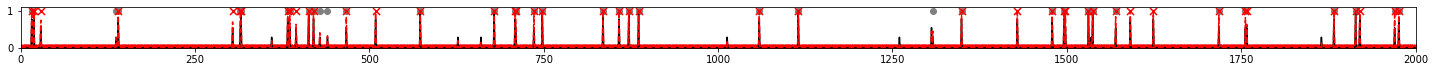

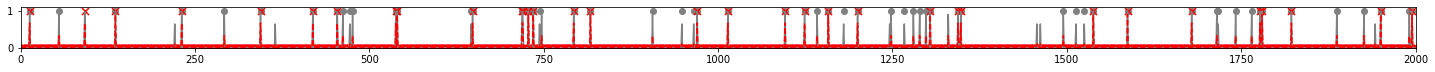

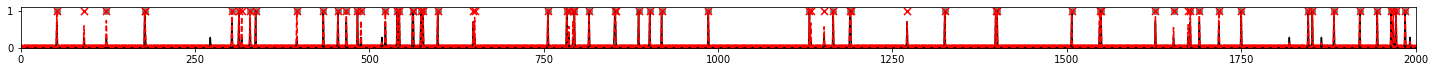

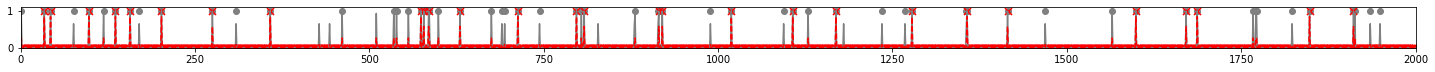

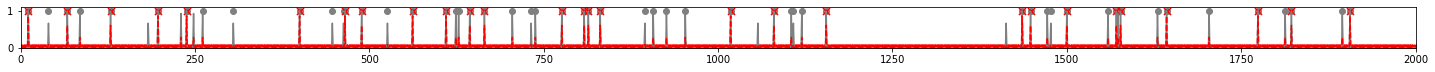

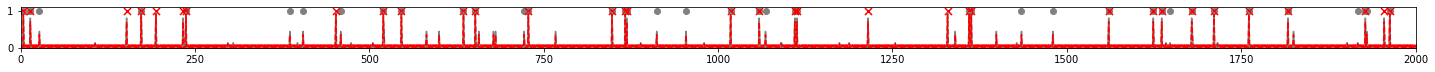

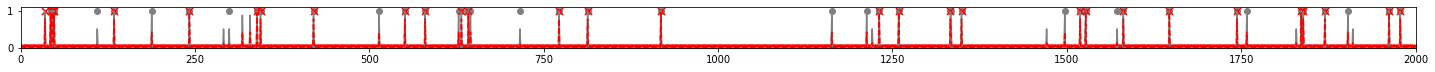

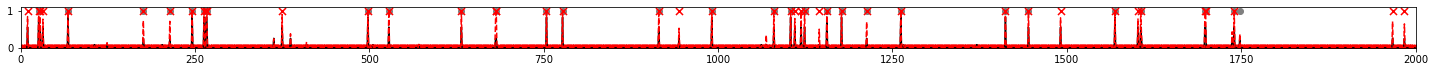

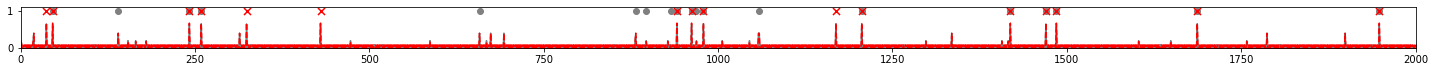

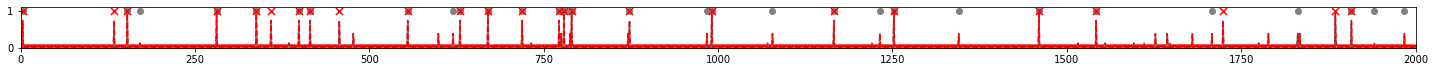

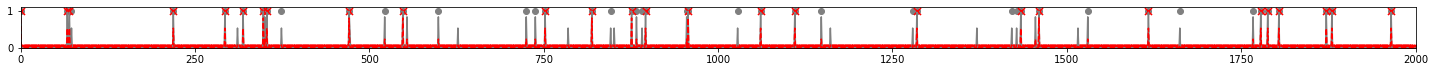

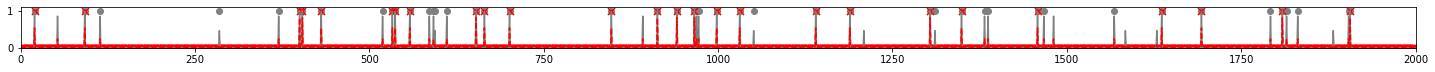

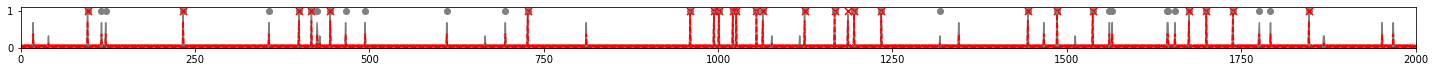

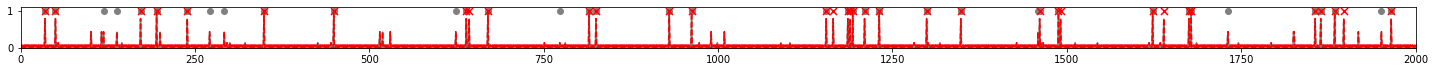

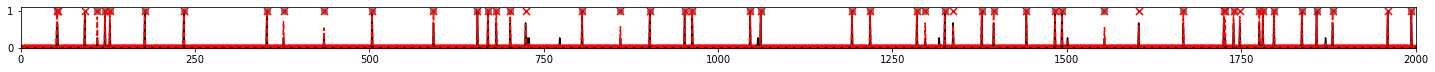

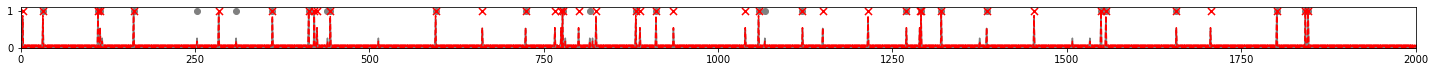

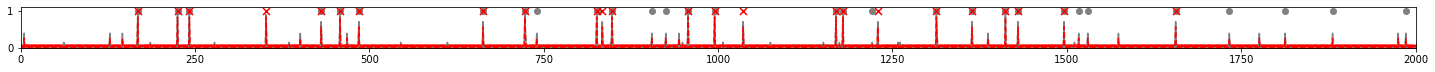

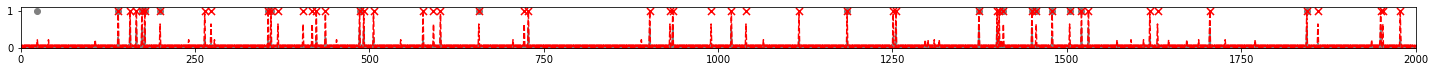

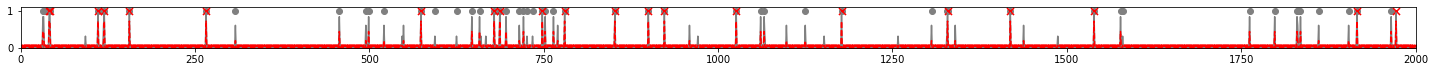

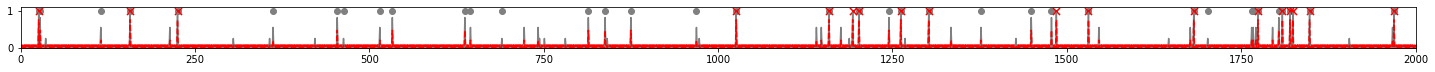

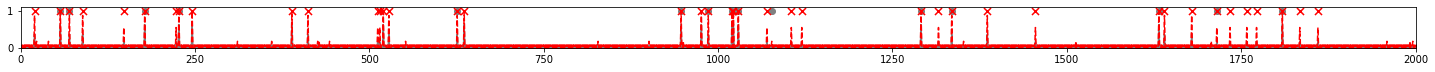

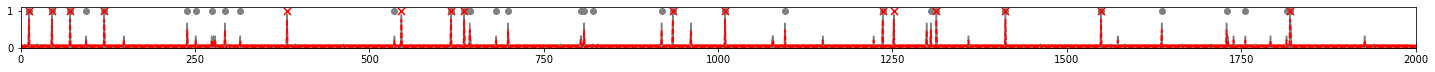

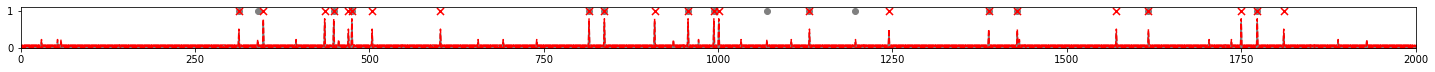

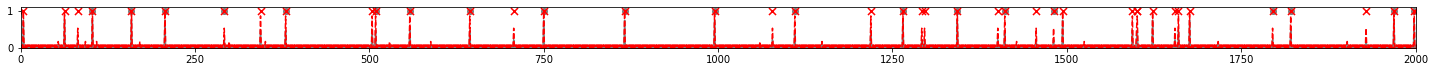

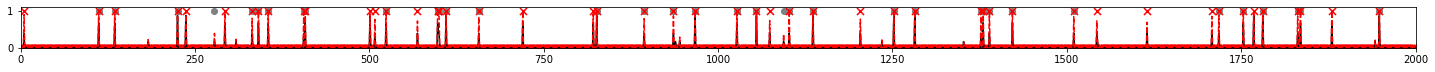

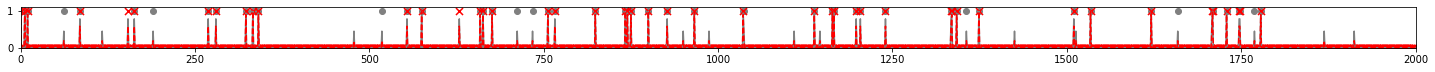

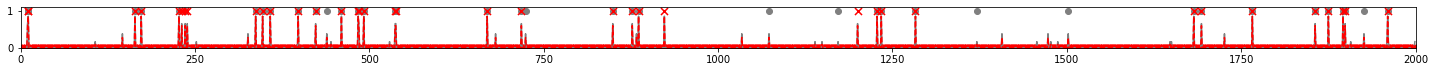

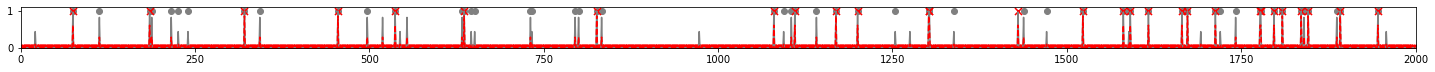

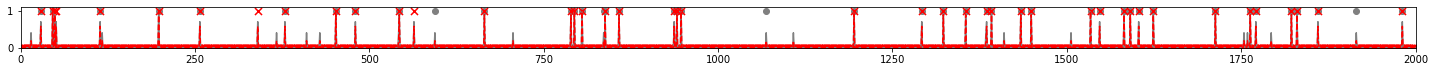

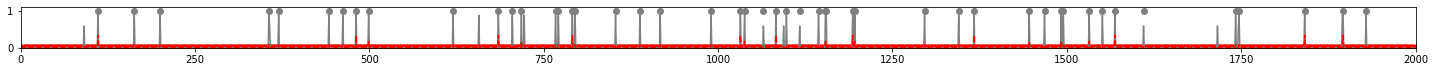

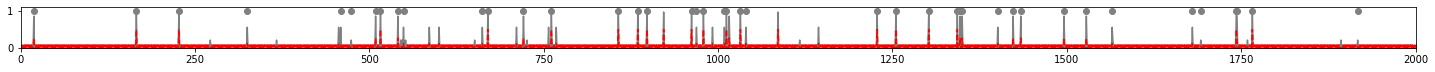

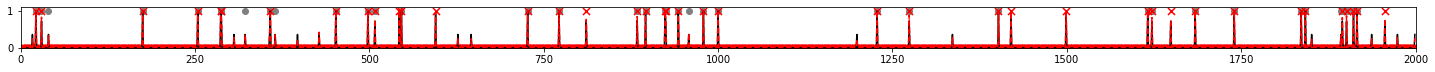

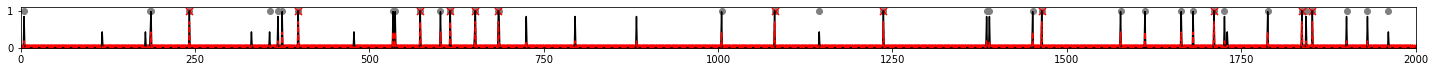

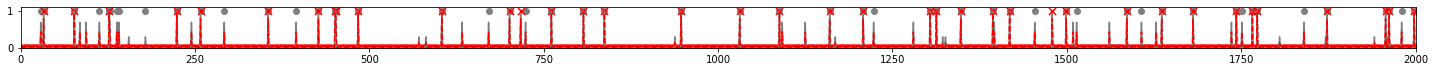

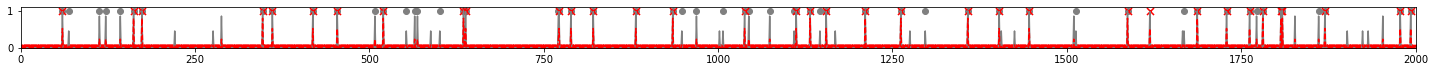

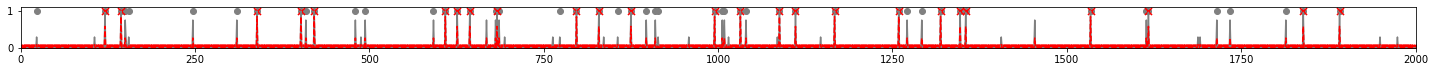

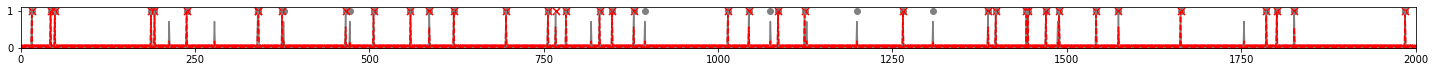

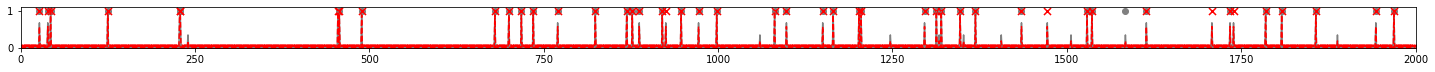

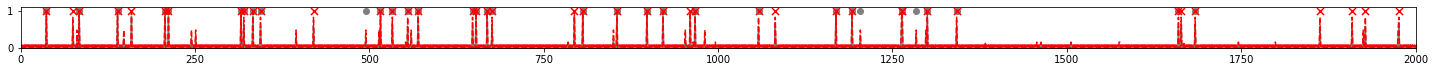

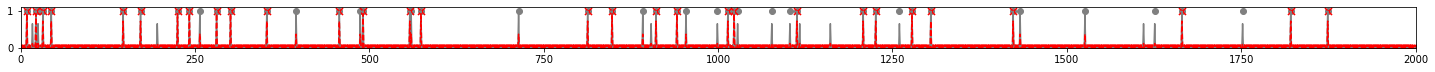

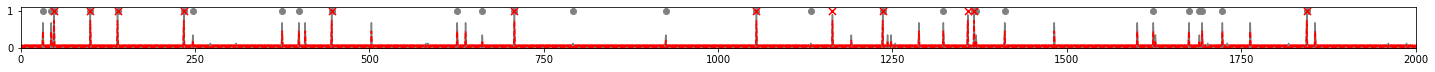

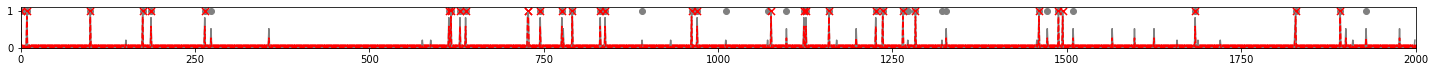

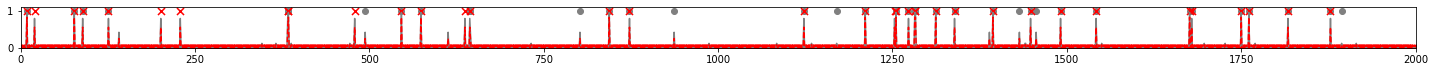

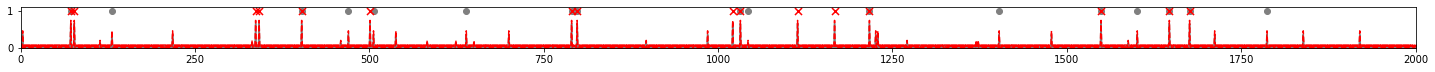

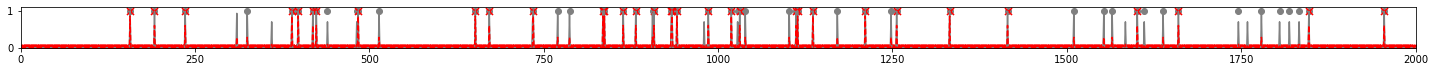

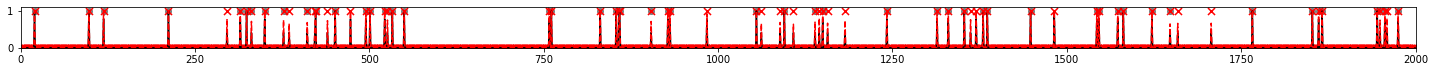

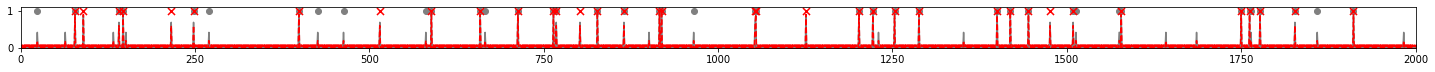

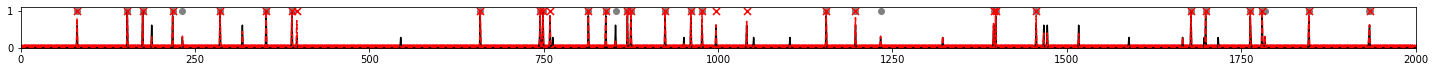

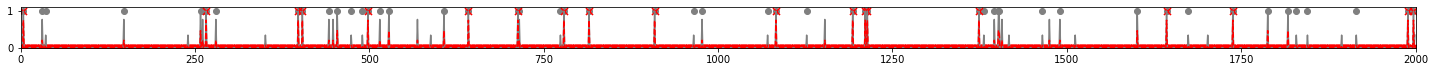

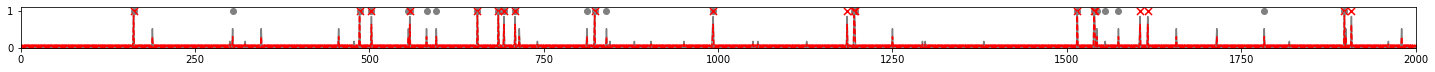

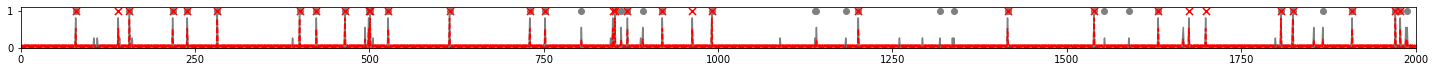

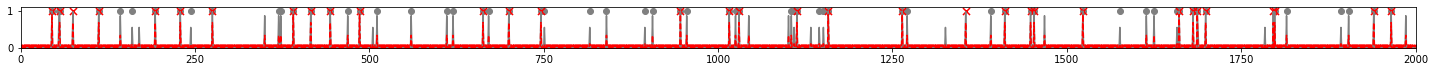

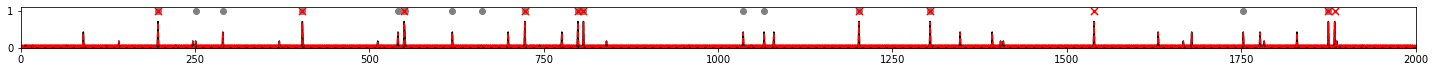

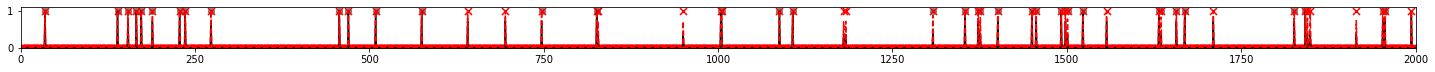

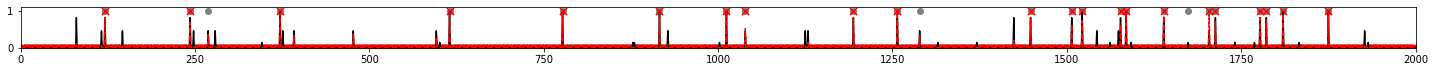

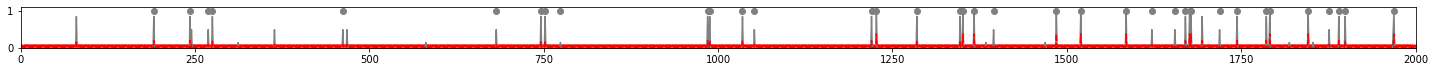

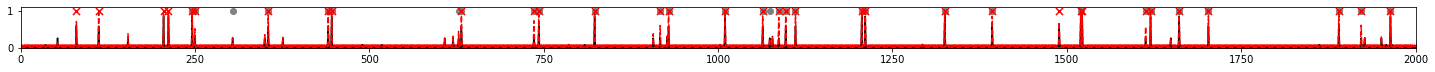

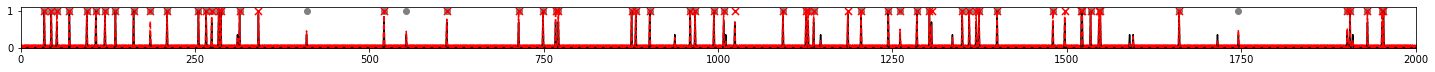

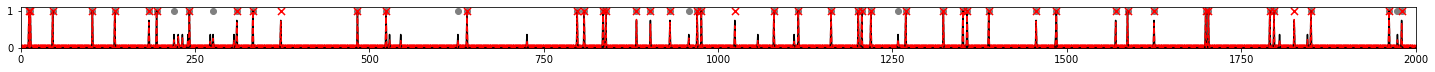

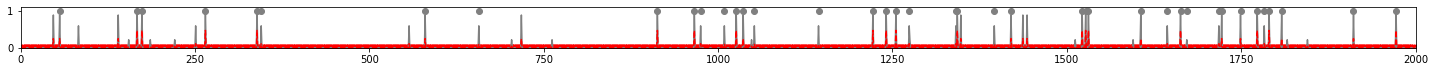

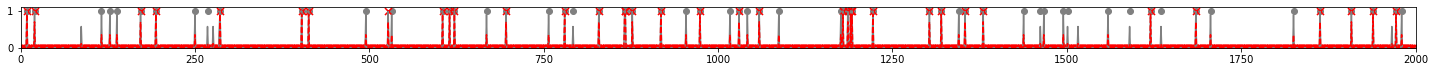

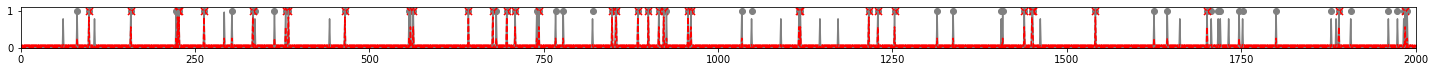

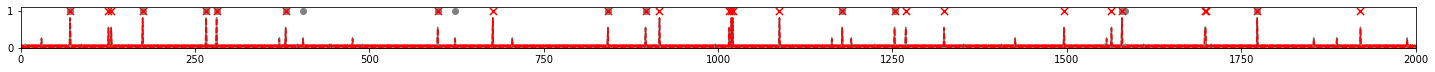

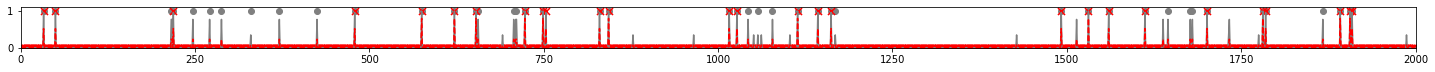

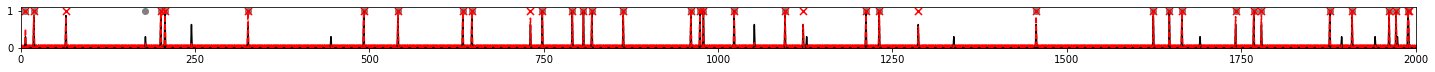

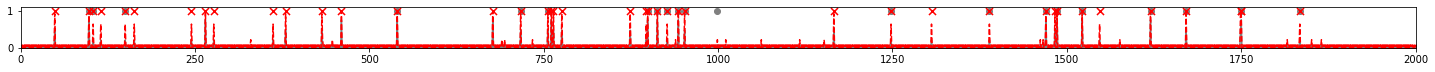

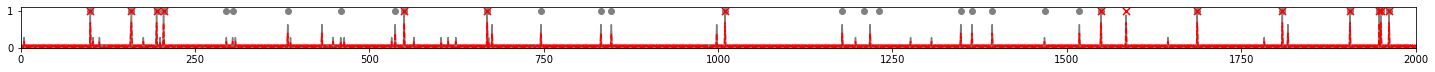

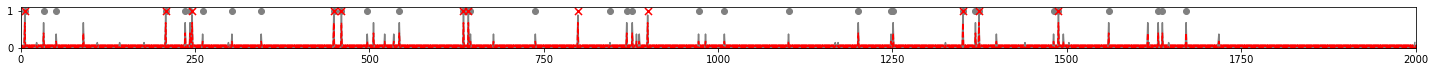

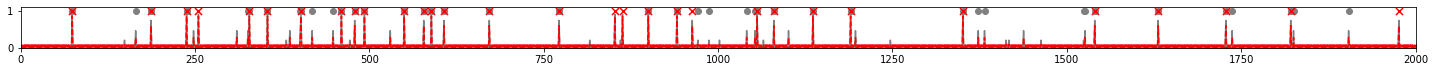

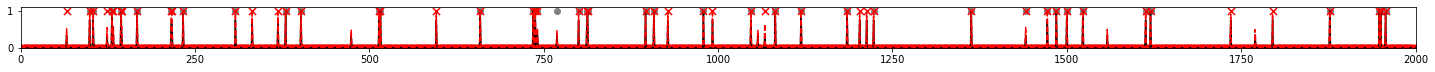

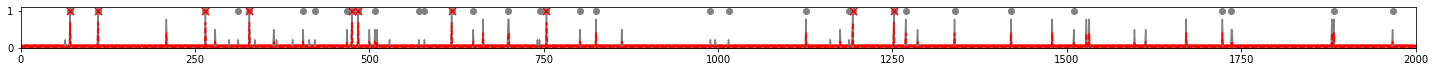

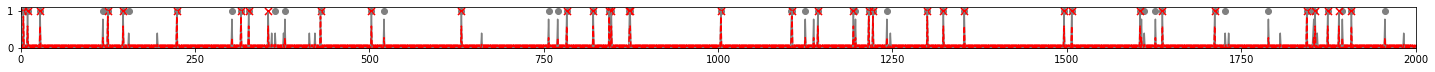

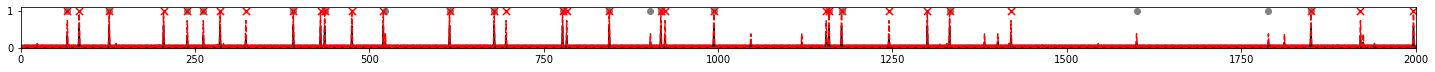

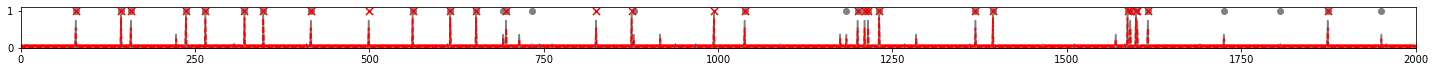

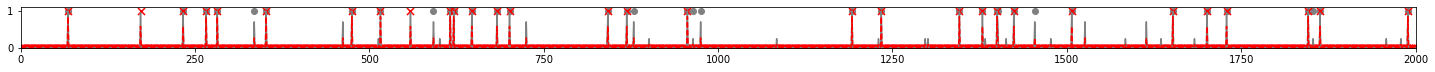

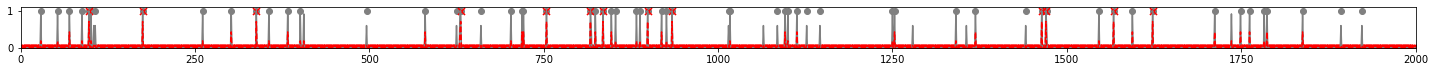

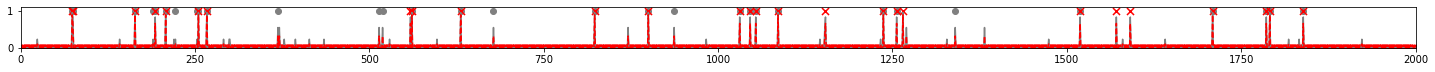

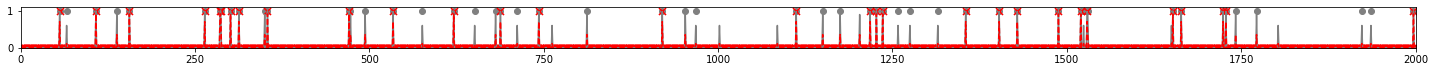

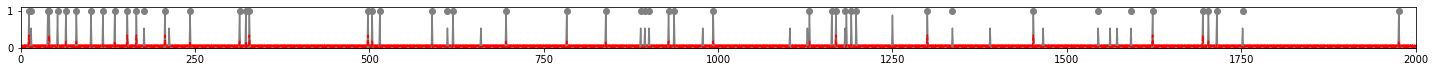

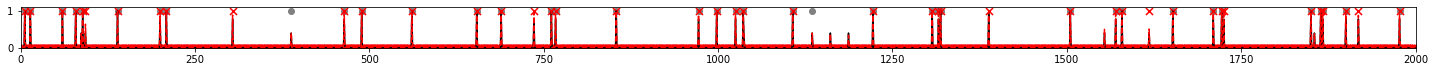

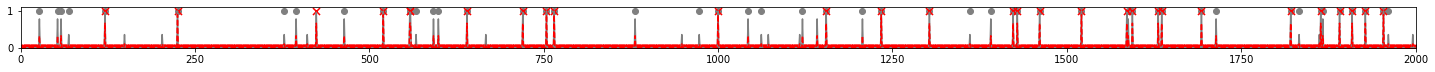

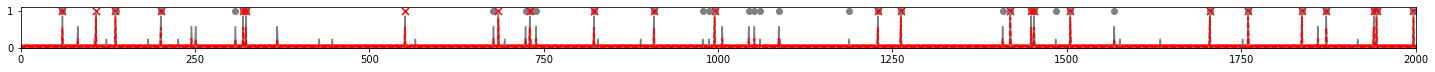

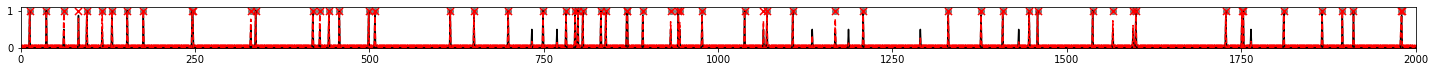

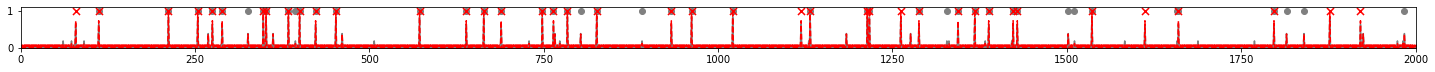

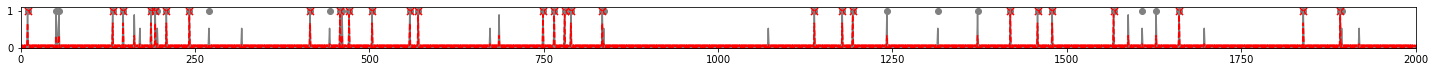

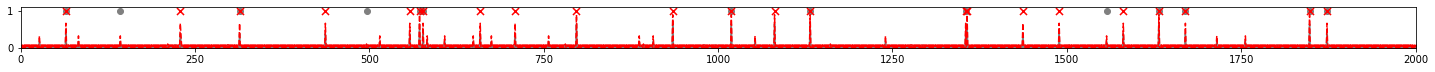

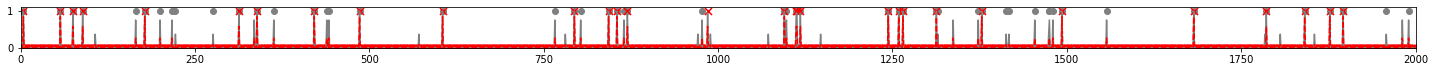

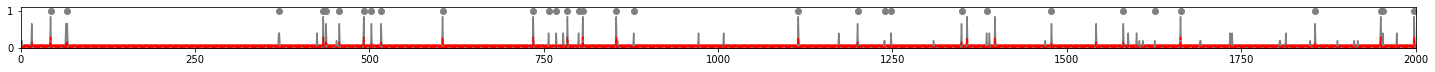

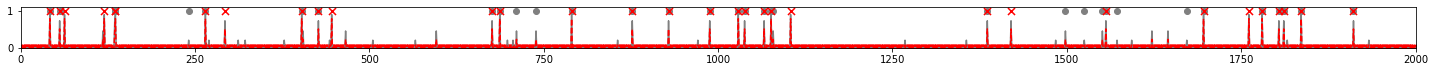

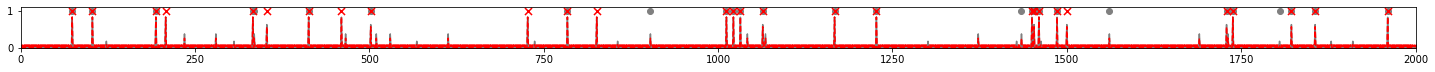

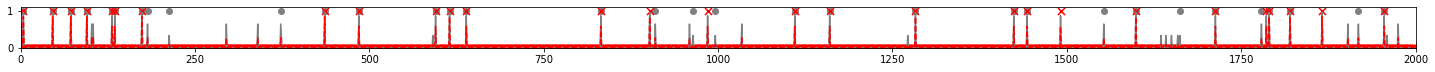

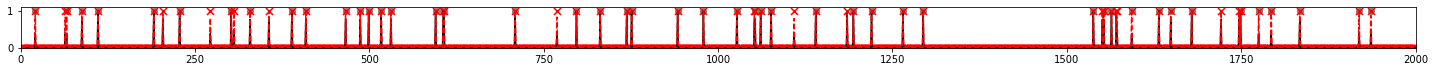

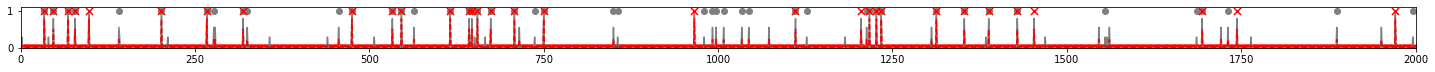

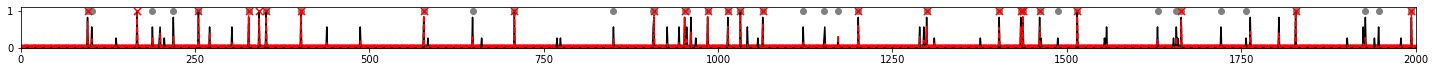

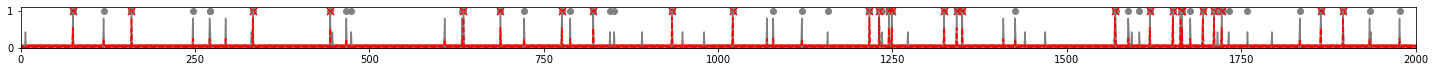

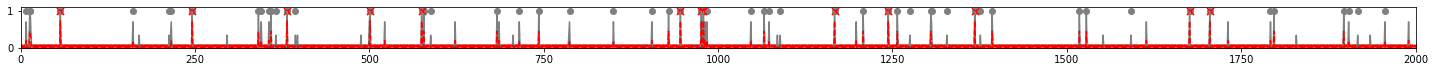

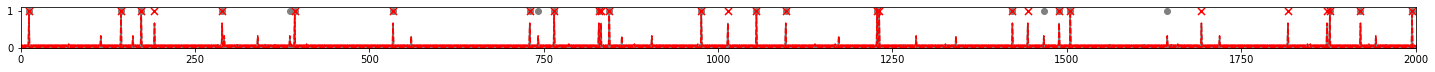

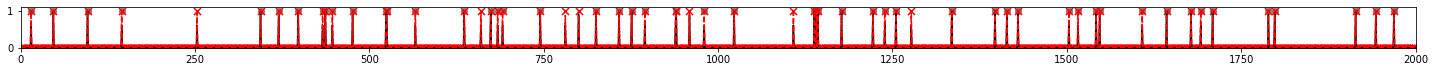

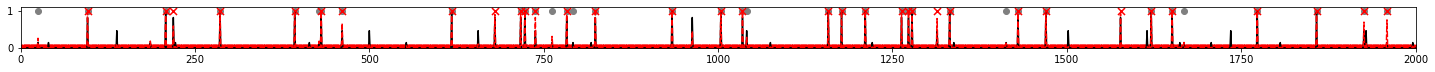

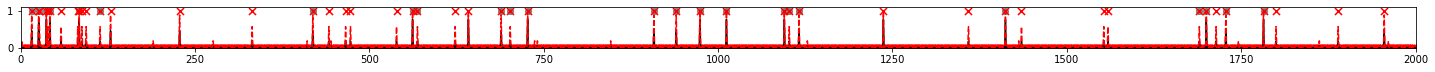

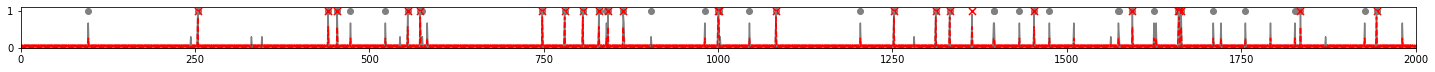

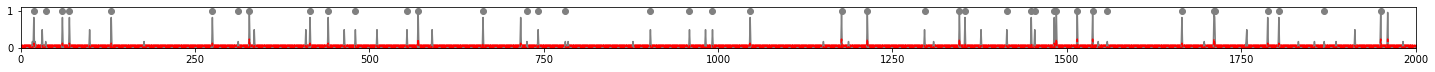

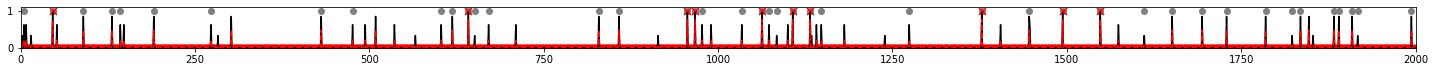

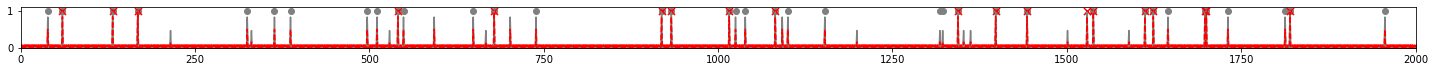

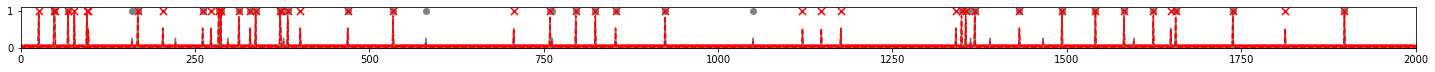

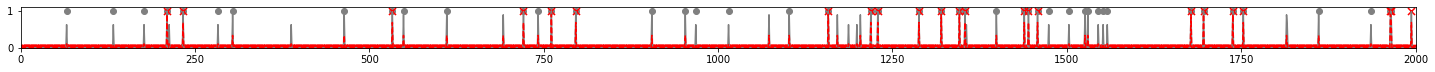

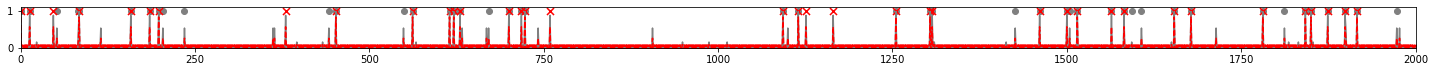

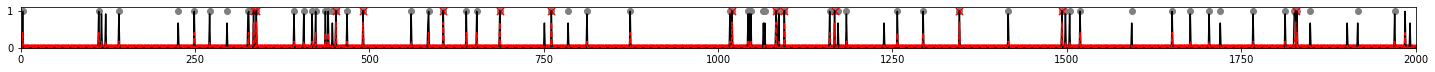

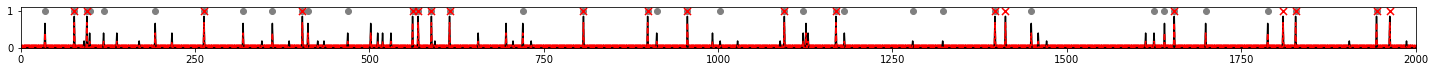

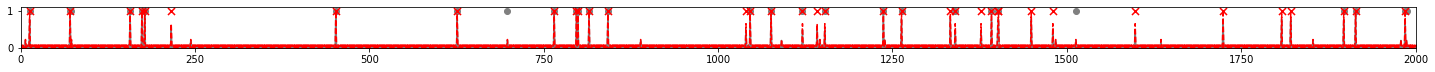

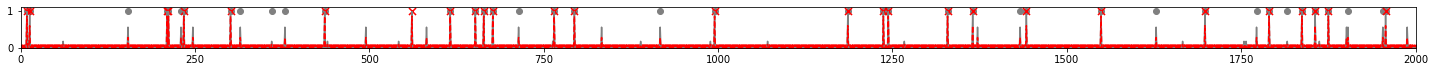

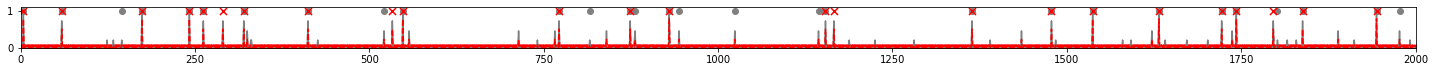

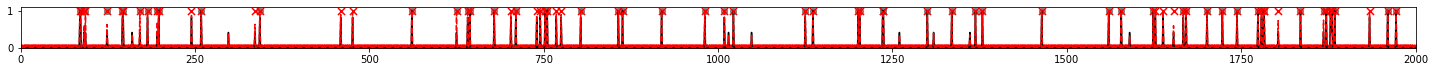

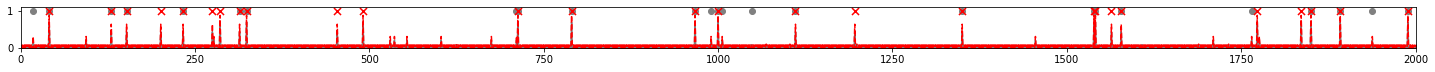

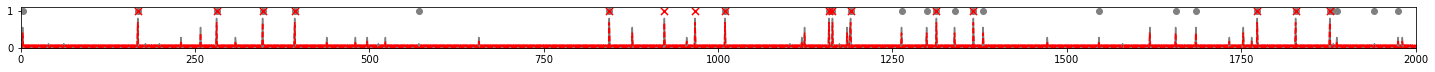

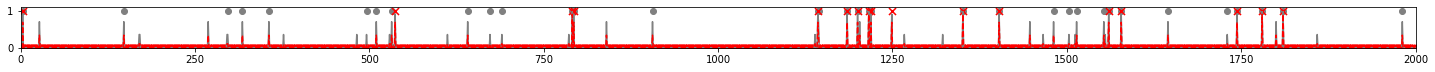

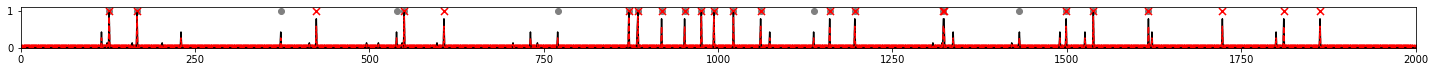

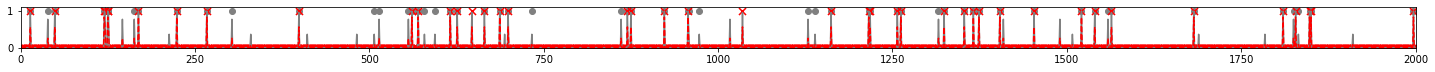

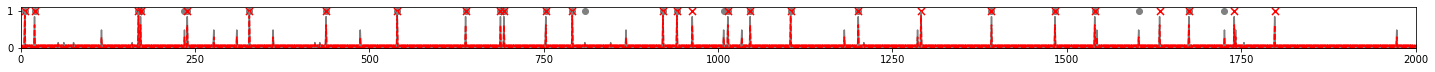

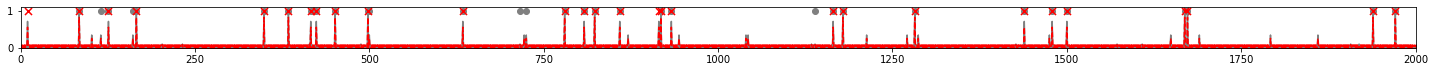

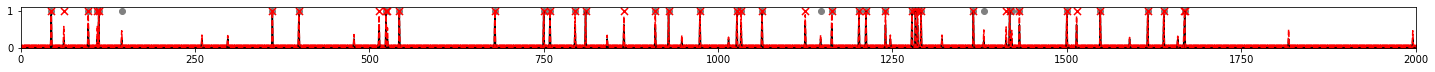

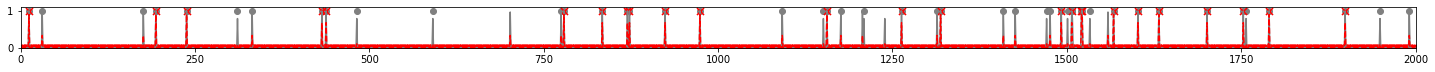

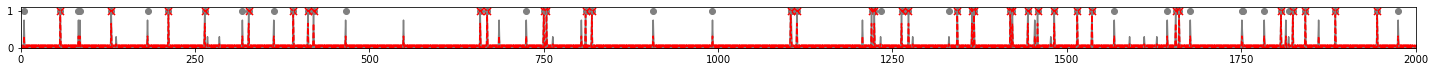

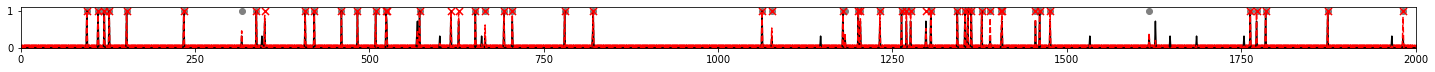

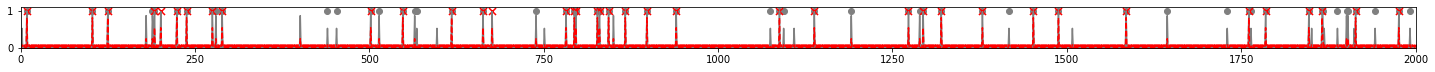

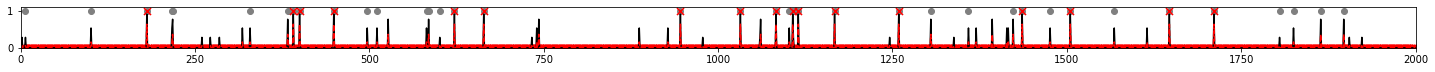

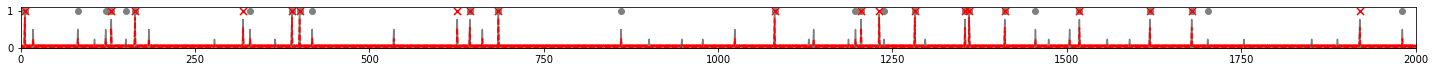

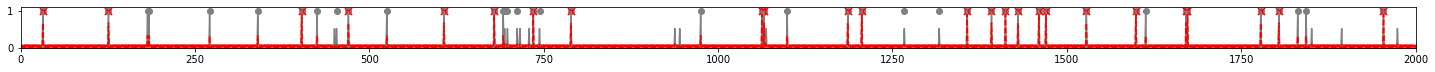

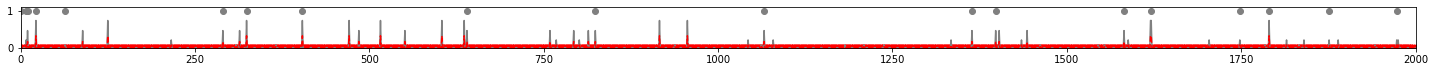

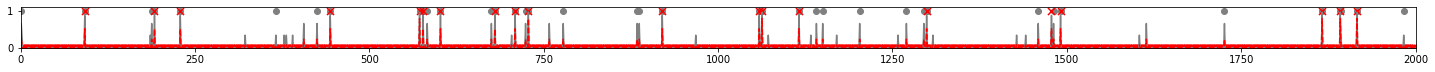

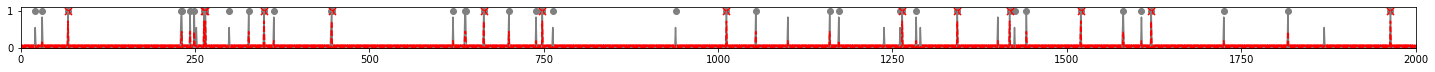

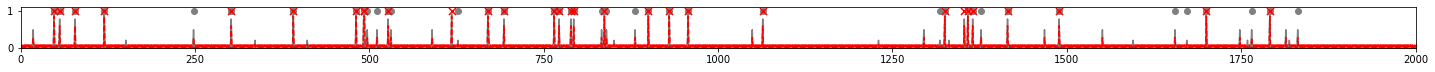

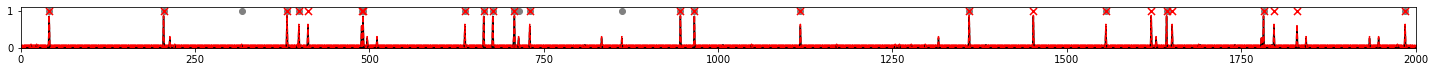

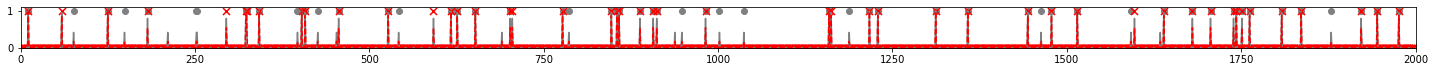

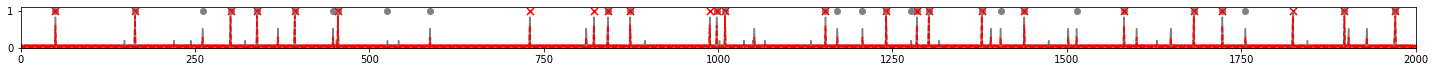

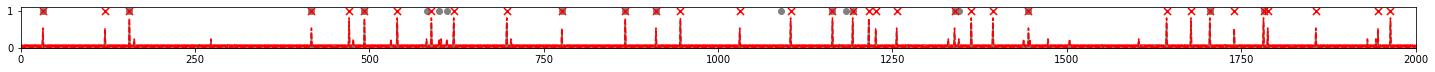

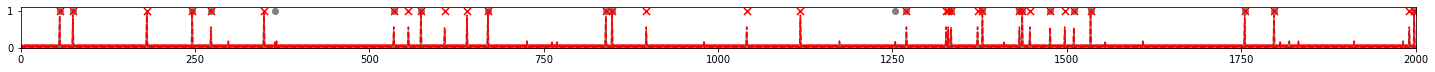

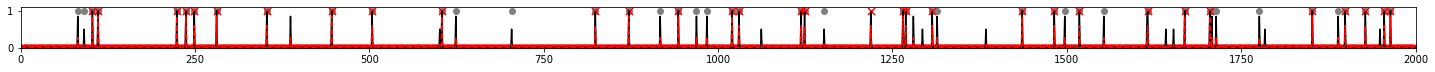

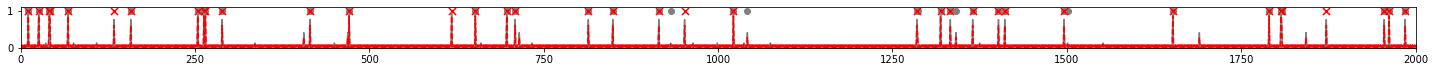

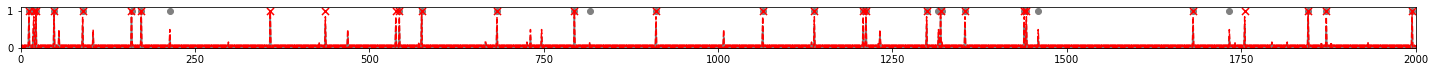

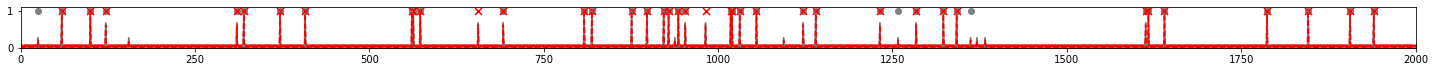

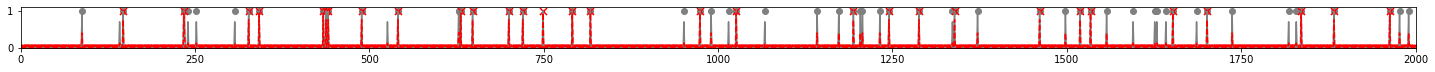

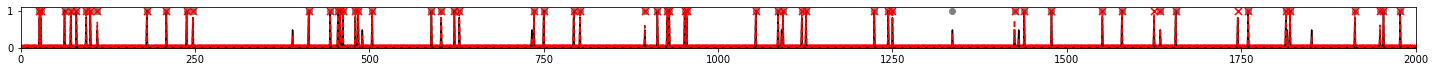

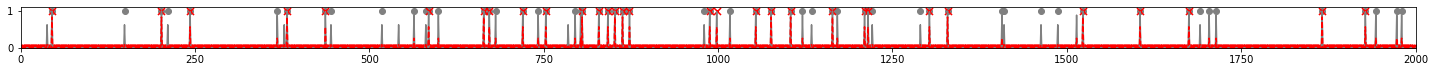

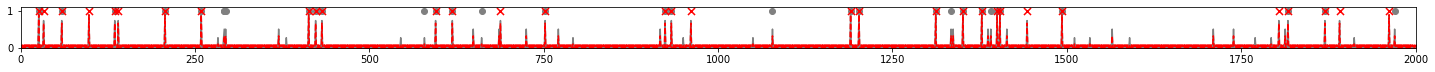

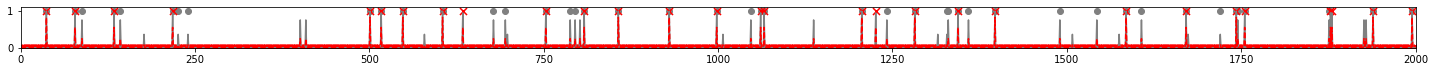

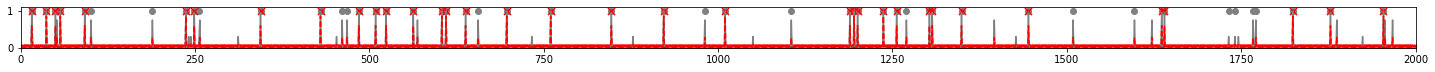

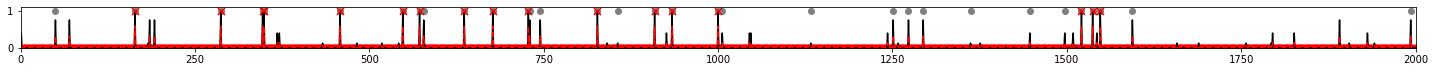

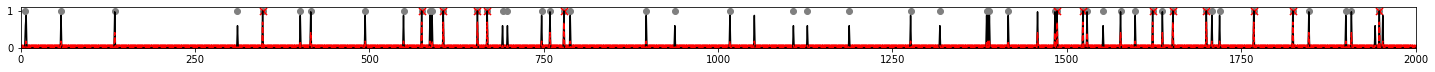

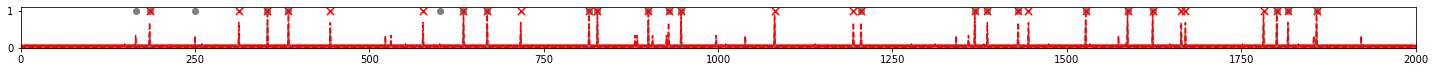

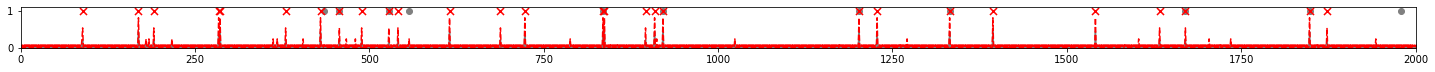

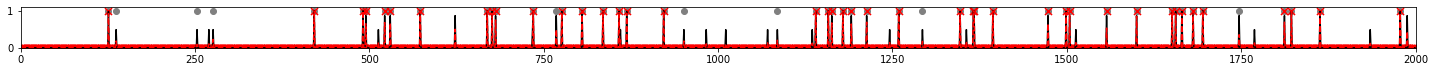

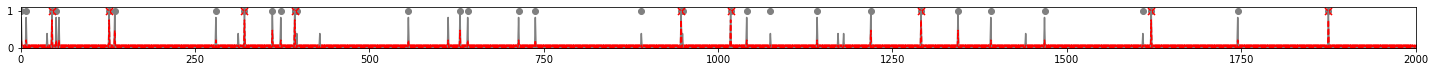

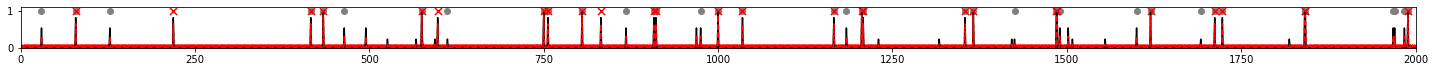

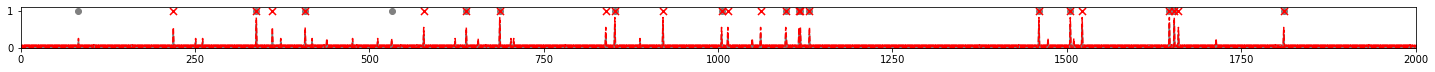

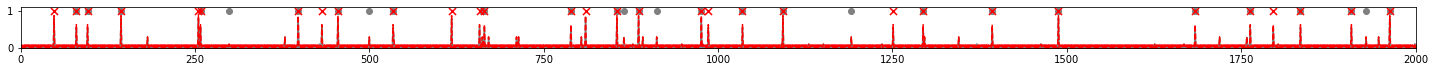

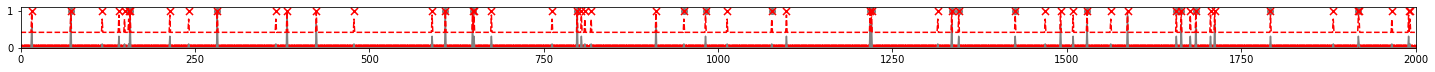

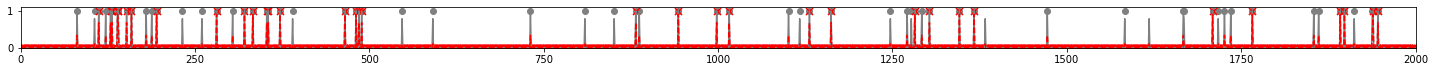

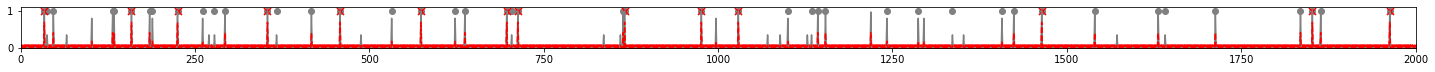

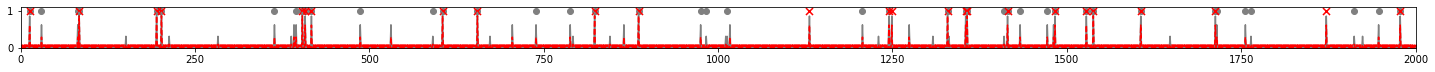

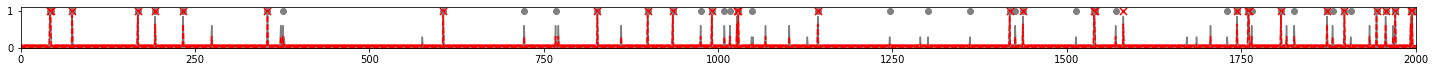

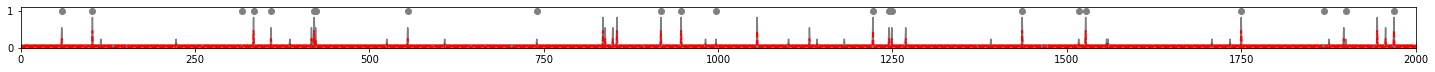

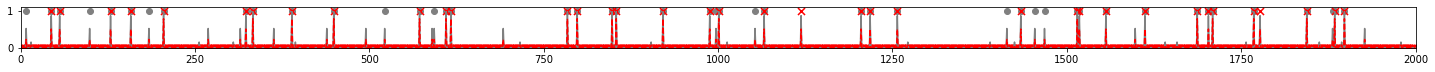

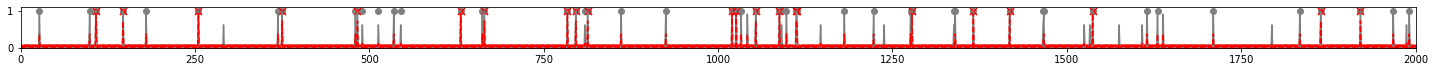

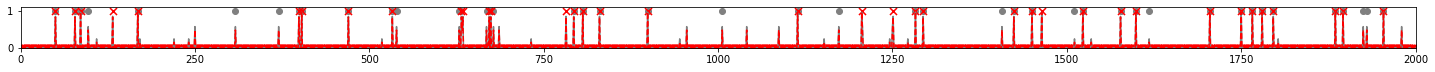

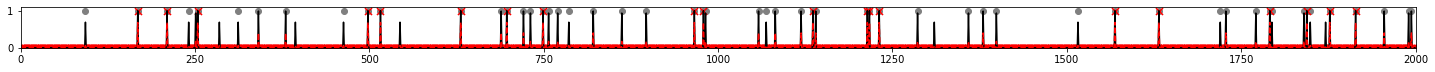

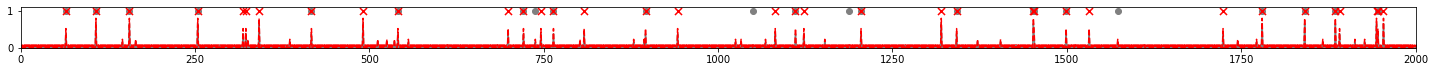

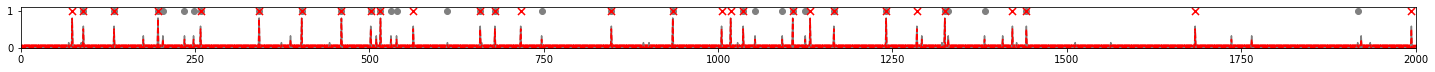

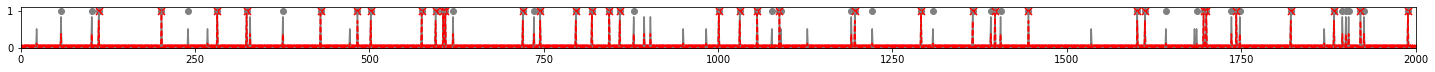

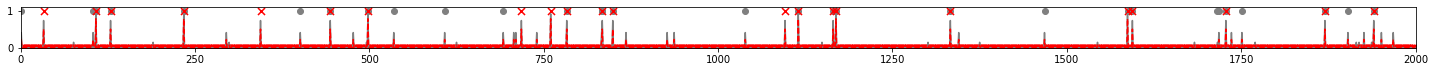

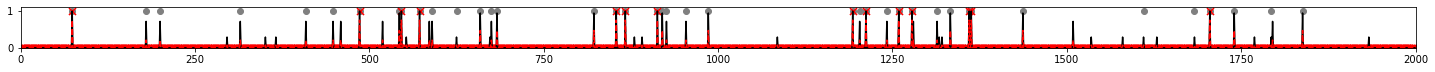

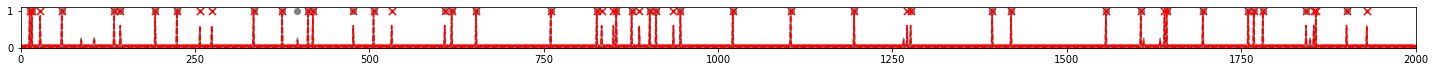

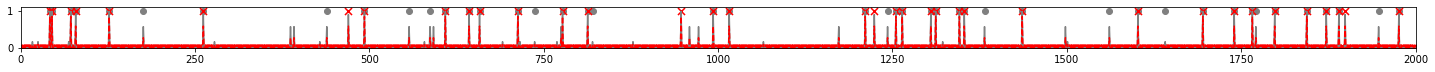

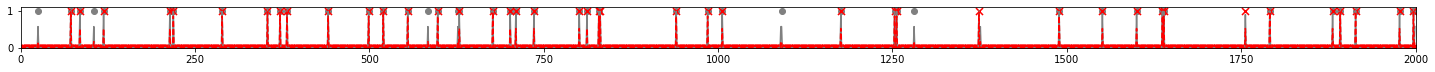

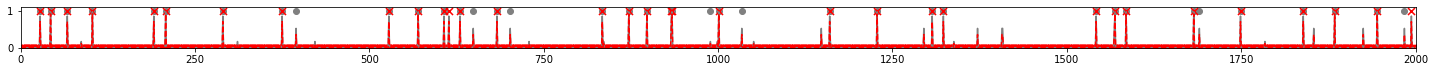

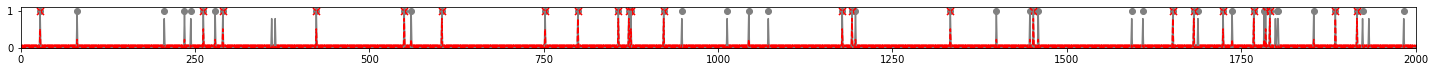

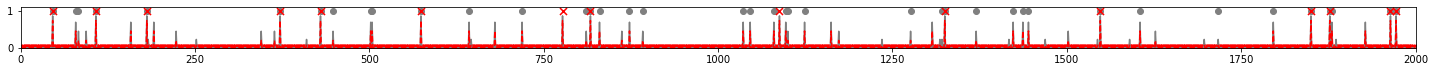

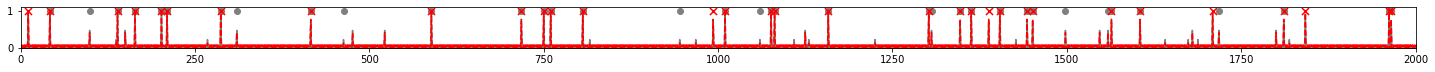

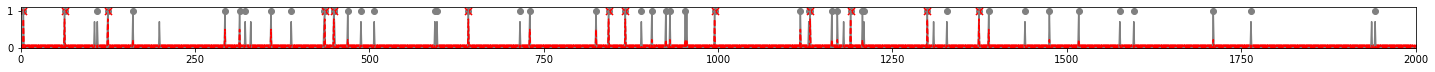

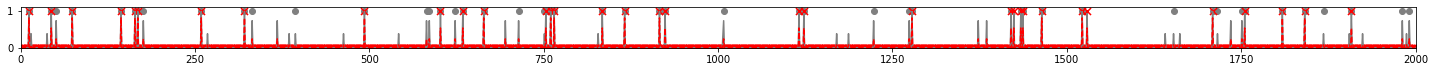

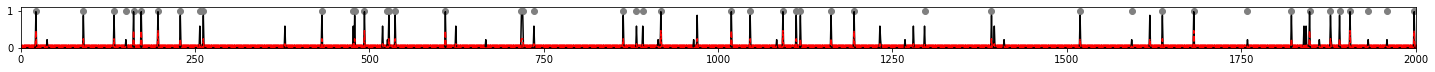

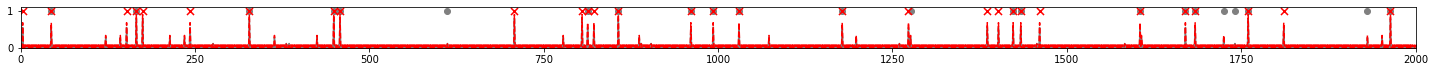

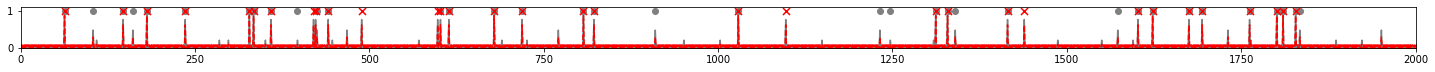

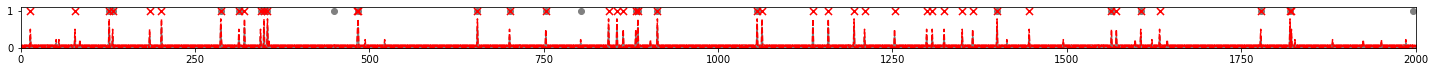

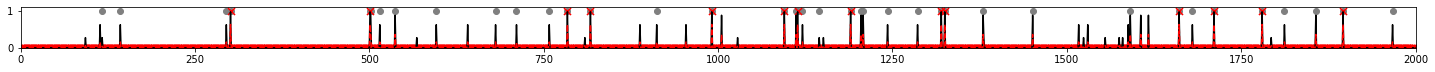

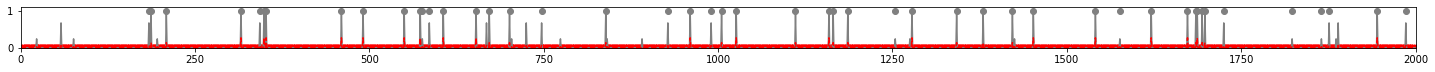

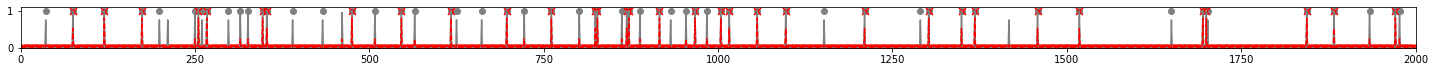

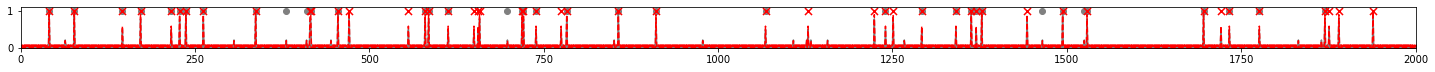

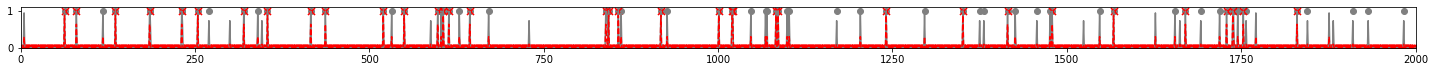

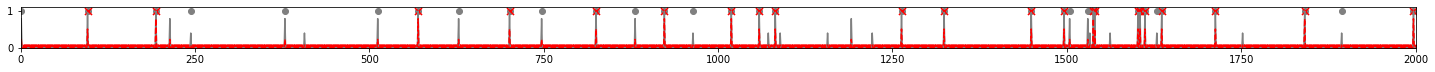

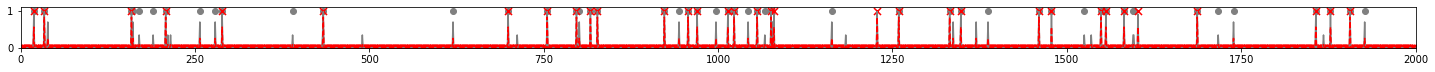

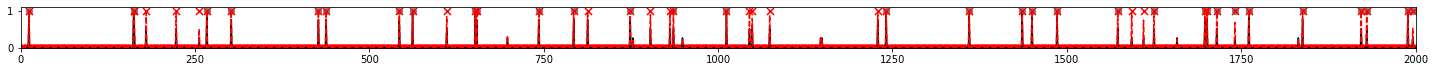

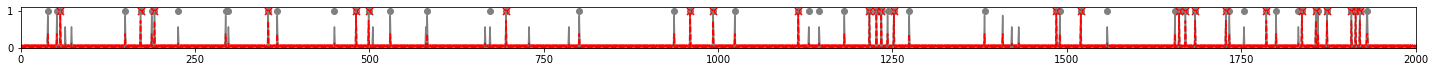

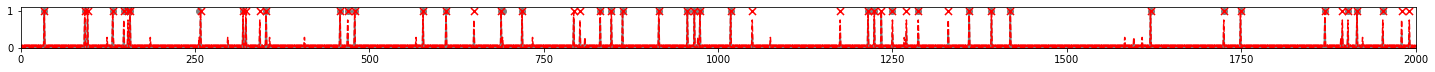

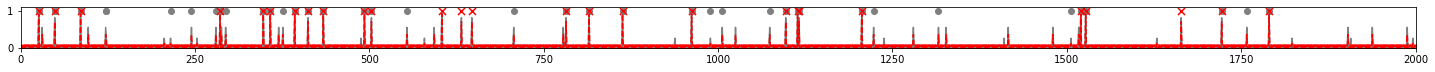

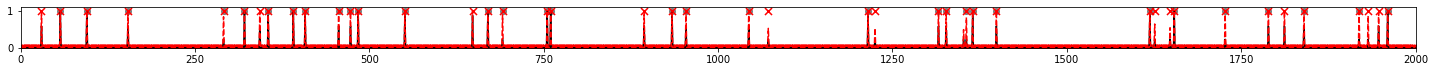

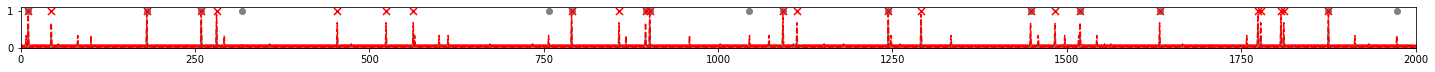

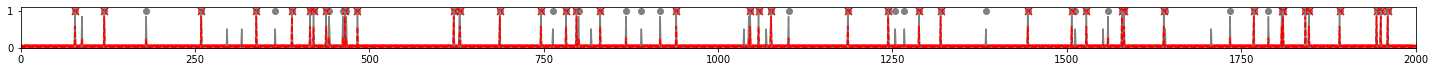

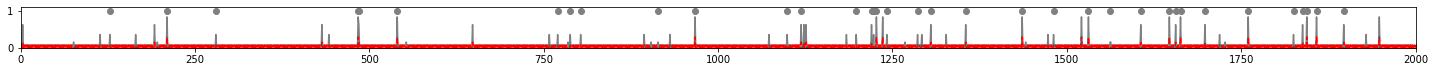

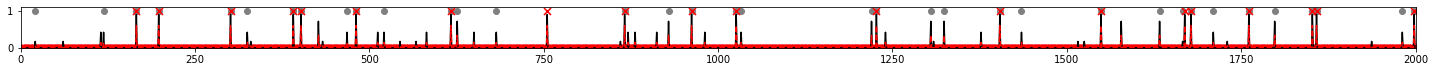

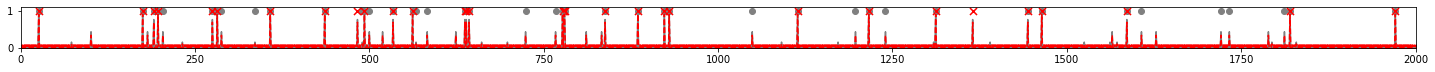

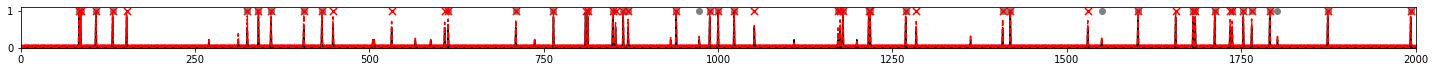

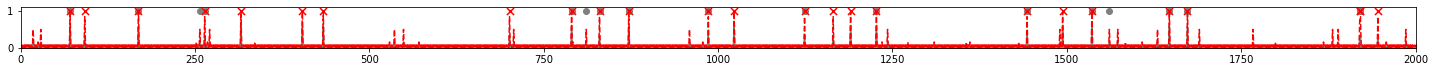

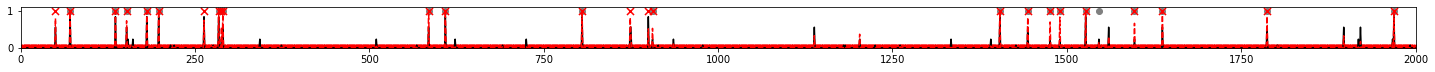

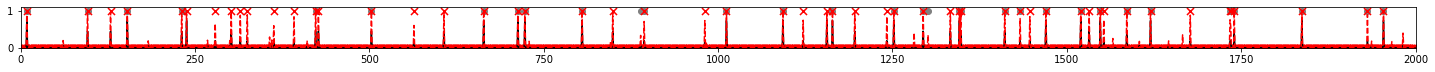

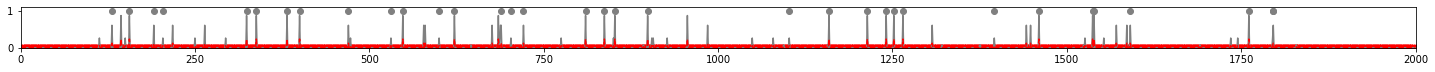

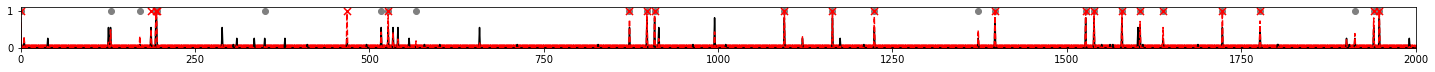

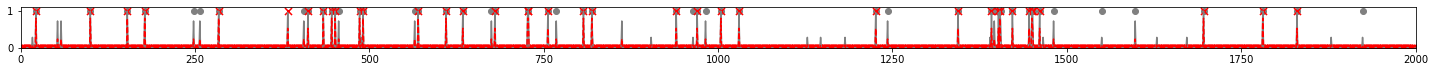

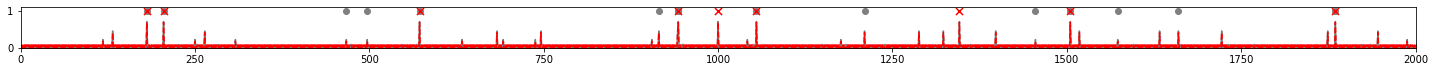

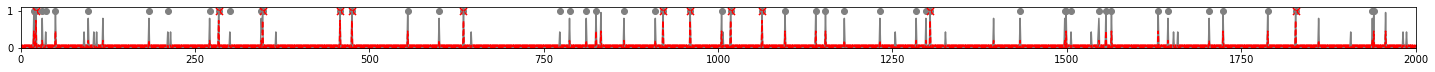

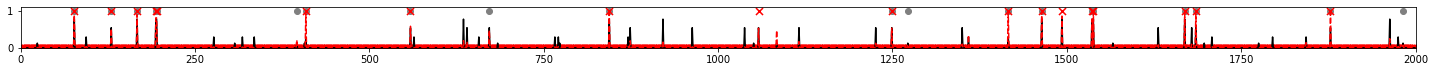

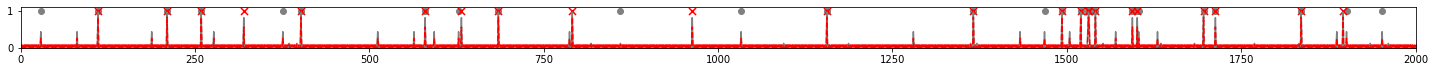

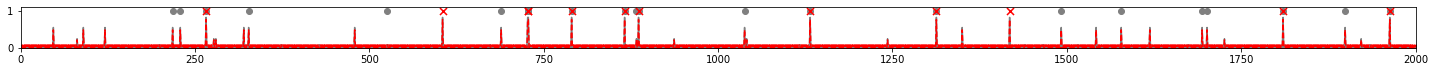

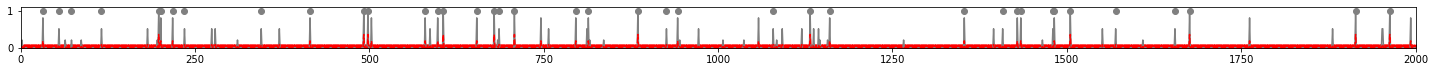

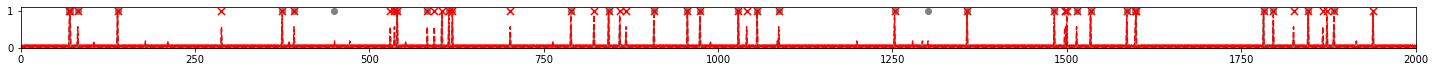

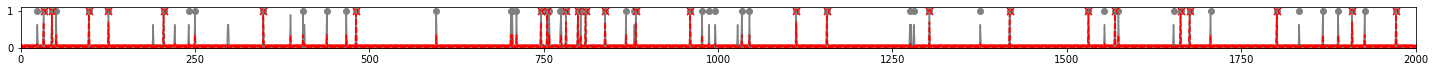

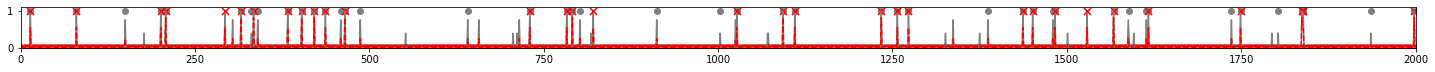

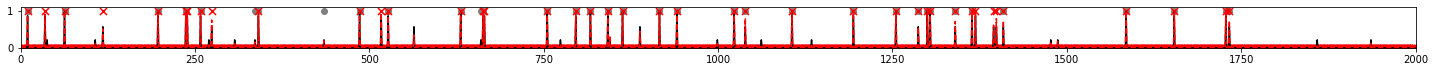

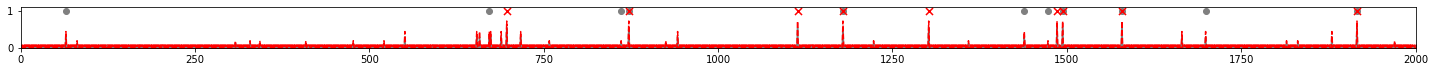

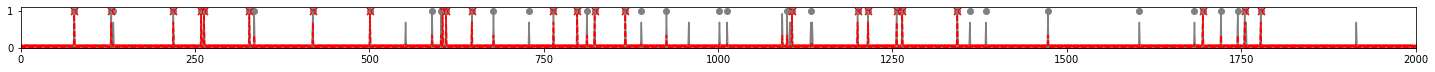

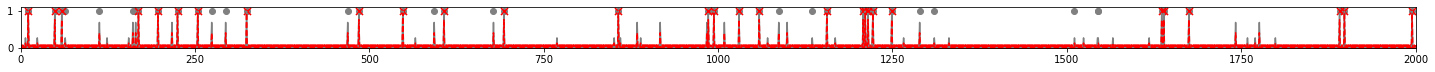

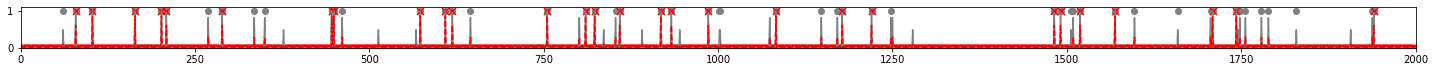

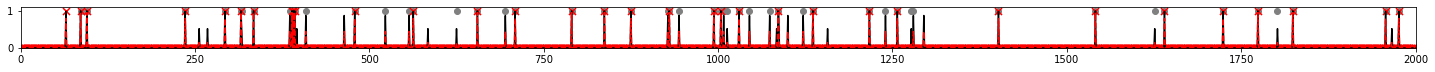

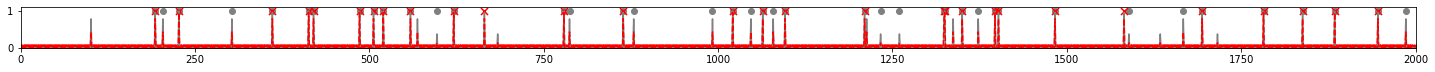

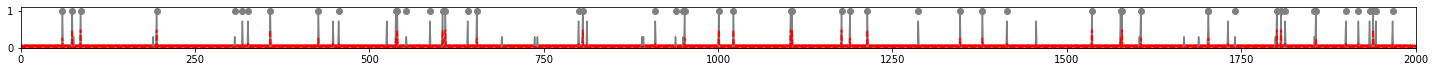

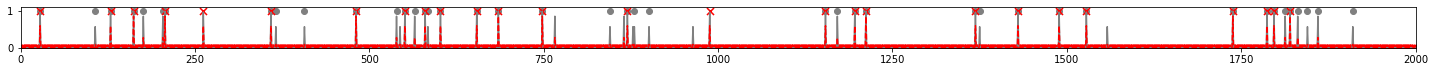

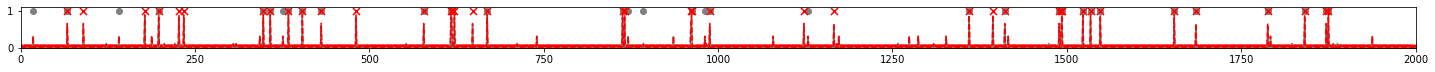

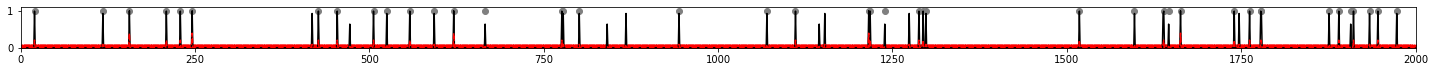

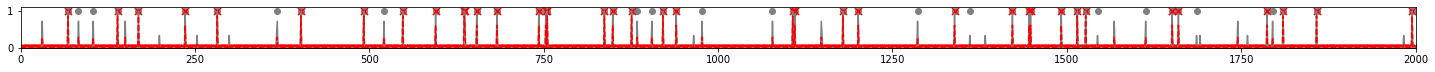

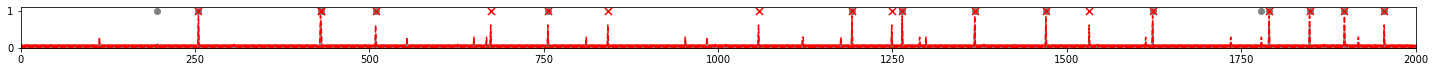

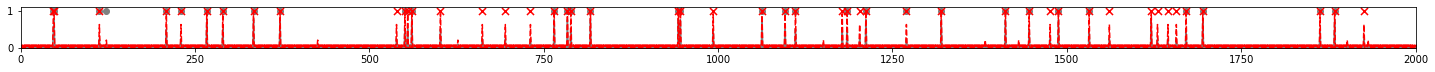

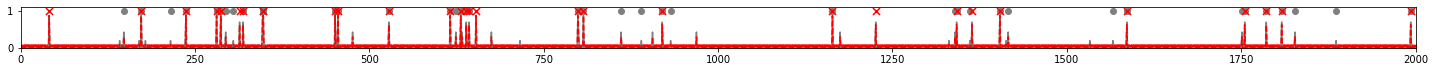

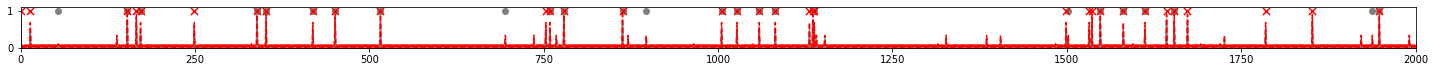

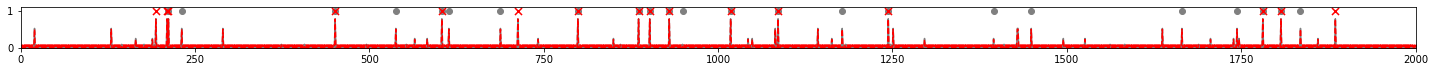

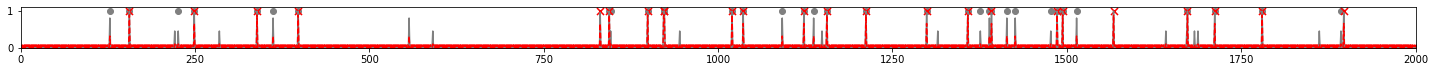

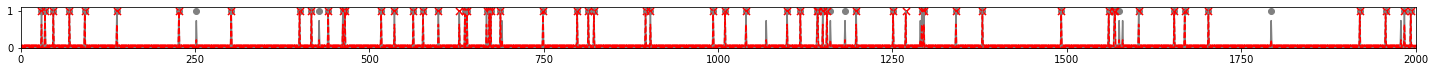

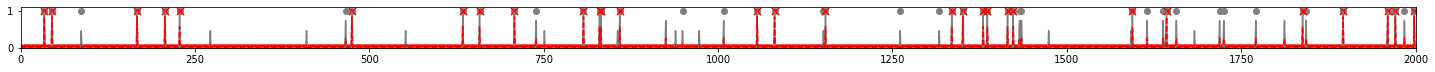

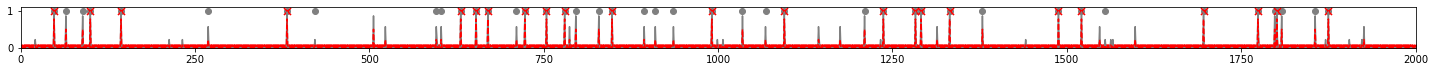

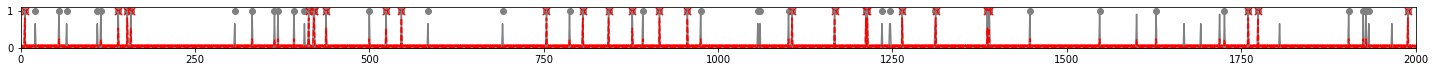

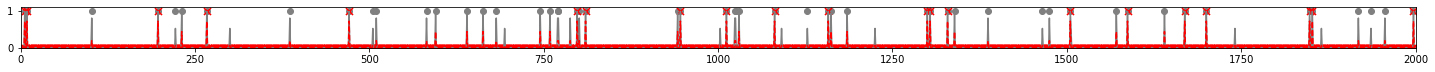

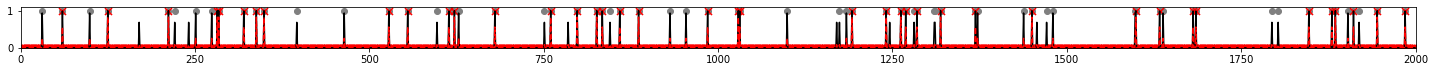

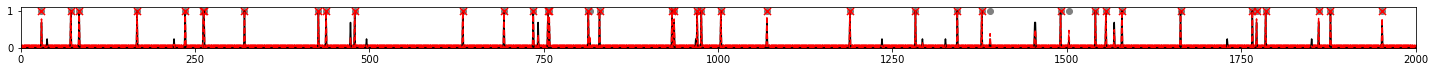

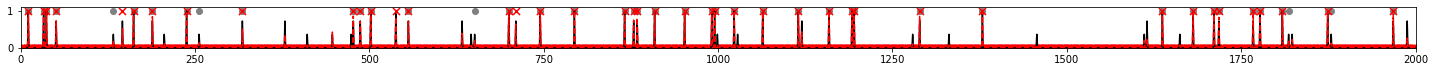

In [34]:
plot_spike_pred(model, sim)

In [35]:
model.state['mu']

DeviceArray([ 4.27679688e-01, -1.87121439e+00, -3.21757793e+00,
             -1.73173409e+01,  2.40049064e-01, -7.69554257e-01,
             -9.40303993e+00, -9.05512273e-01, -1.79422550e+01,
             -1.02059376e+00,  1.78748715e+00,  1.10676658e+00,
              2.16484115e-01, -1.16308289e+01,  1.28068316e+00,
             -1.81349182e+01, -1.33089066e+00,  1.59398559e-02,
              1.98899472e+00,  9.24415052e-01, -1.28003416e+01,
              8.86118293e-01, -3.63564432e-01,  4.40319002e-01,
              2.83109879e+00, -3.19110930e-01,  2.14127302e+00,
             -1.73095341e+01,  9.60013092e-01,  2.62674117e+00,
             -1.04419363e+00, -7.54899681e-01, -1.13903904e+00,
              5.39271355e-01,  1.65385768e-01,  1.79498994e+00,
             -5.90240598e-01, -8.92130470e+00,  1.71560681e+00,
              1.05182409e+00,  1.06713271e+00,  8.92999530e-01,
              5.46061563e+00,  9.67377722e-01, -6.67858171e+00,
             -1.86429195e+01,  1.2986686

In [36]:
alpha = model.state['alpha']
w_est = model.state['mu'] * alpha
beta = model.state['beta']

In [37]:
bin_stimulus_matrix = stim.copy()
bin_stimulus_matrix[stim > 0] = 1

In [38]:
sparse_lasso = Lasso(alpha=1e-2, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

Lasso(alpha=0.01, fit_intercept=False)

(-23.0, 4.0)

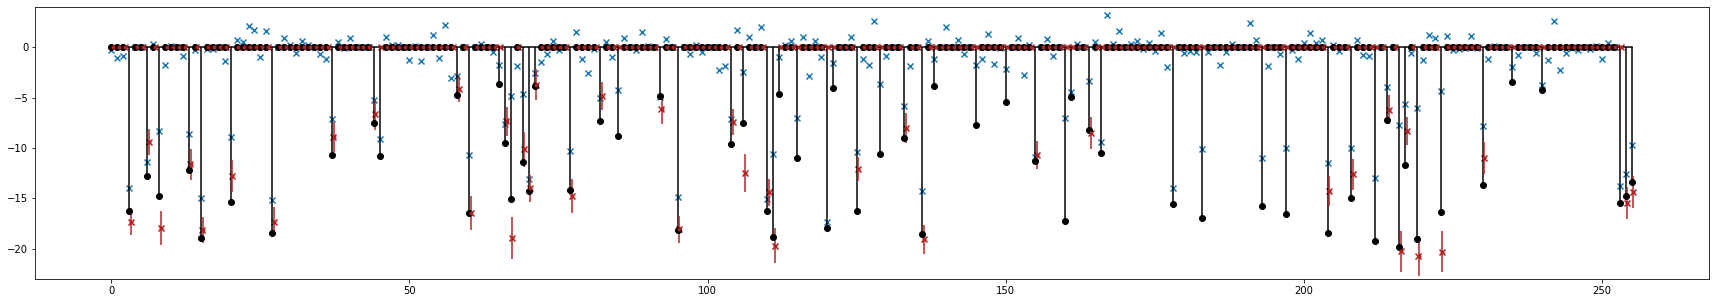

In [39]:
rng = np.arange(N)
model_offset = 0.25

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
plt.scatter(rng + model_offset, w_est, marker='x', color='firebrick', label='Model')
plt.errorbar(rng + model_offset + 0.03, w_est, yerr= beta * (alpha >= 0.5), fmt='.', color='firebrick')
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')

plt.ylim(top=4, bottom=-23)

In [40]:
locs = np.where(w_est < 0)[0]

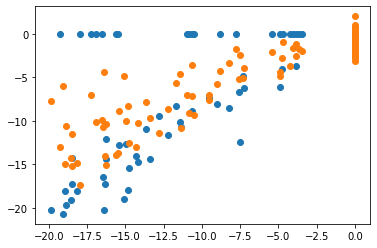

In [41]:
plt.scatter(sim.w[locs], w_est[locs])
plt.scatter(sim.w[locs], sparse_lasso.coef_[locs])

In [42]:
np.corrcoef(sim.w[locs], w_est[locs])[0, 1]

0.7775236422595997

In [43]:
np.corrcoef(sim.w[locs], sparse_lasso.coef_[locs])[0, 1]

0.9135077367678741

In [44]:
model.state['mu'][21]

DeviceArray(0.8861183, dtype=float32)

In [45]:
def get_gauss_fn(mu, sig):
    def func(x):
        return 1/np.sqrt(2 * np.pi * sig**2) * np.exp(-(x - mu)**2/(2 * sig**2))
    return func

In [46]:
phi = model.state['phi']
phi_cov = model.state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - phi_sdevs
phigh = phi + phi_sdevs

phi_true = np.c_[sim.phi_0, sim.phi_1]

In [47]:
Irng = np.arange(0, 61)

KeyboardInterrupt: 

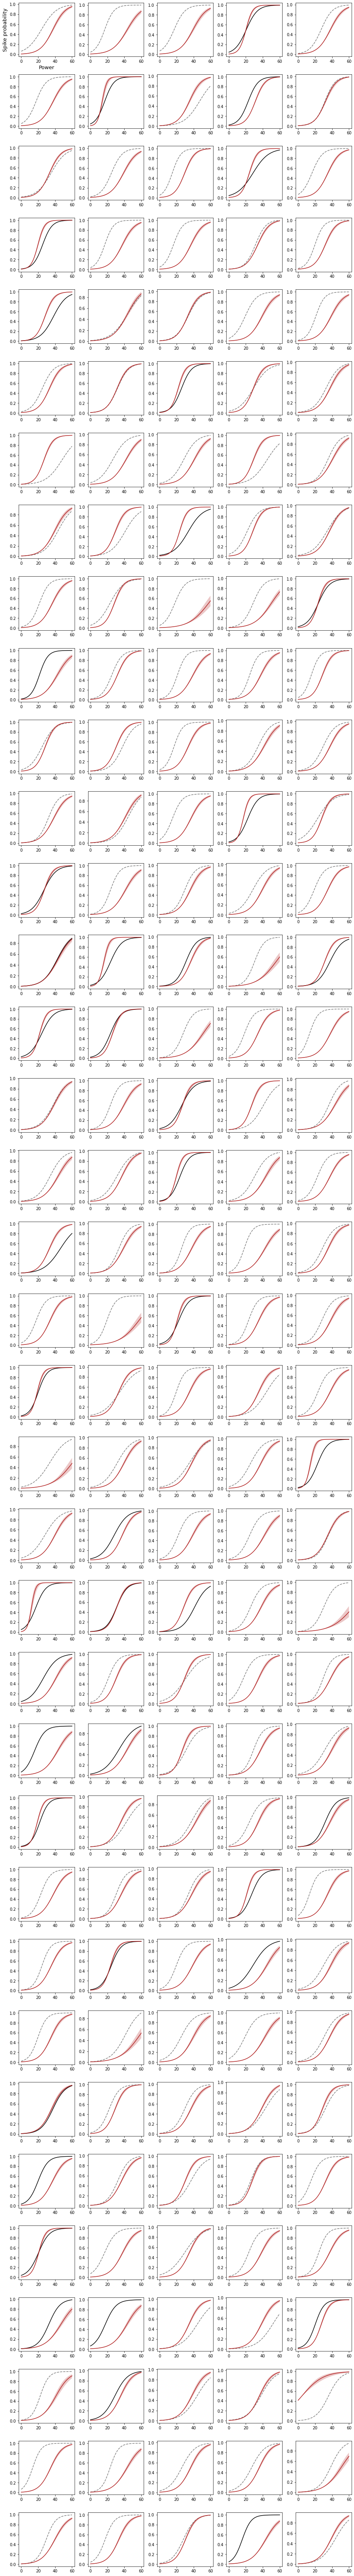

In [48]:
ncols = 5
nrows = int(np.ceil(N/ncols))
panel_size = 2.5
plt.figure(figsize=(ncols * panel_size, nrows * panel_size))
for n in range(N):
    plt.subplot(nrows, ncols, n + 1)
    if sim.z[n]:
        true_col = 'k'
        linestyle='-'
    else:
        true_col = 'gray'
        linestyle='--'
    plt.plot(sigmoid(phi_true[n, 0] * Irng - phi_true[n, 1]), linestyle=linestyle, color=true_col)
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color='firebrick')
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor='firebrick', edgecolor='None', alpha=0.25)
    if n == 0:
        plt.xlabel('Power', fontsize=fontsize)
        plt.ylabel('Spike probability', fontsize=fontsize)
        
    plt.tight_layout()
plt.show()

# Jax updates

In [ ]:

def _eval_lam_update_monte_carlo(I, phi_0, phi_1):
    fn = sigmoid(phi_0 * I - phi_1)
    return jnp.log(fn/(1 - fn))

_vmap_eval_lam_update_monte_carlo = vmap(_eval_lam_update_monte_carlo, in_axes=(None, 0, 0))


In [ ]:
@jit
def update_beta(alpha, lamk, shape, rate, beta_prev):
    return 1/jnp.sqrt(shape/rate * alpha * lamk + 1/(beta_prev**2))

In [ ]:
@jit # in-place index_updates fast enough?
def update_mu(yk, mu, beta, alpha, lamk, shape, rate, mu_prev, beta_prev, mask):
    N = mu.shape[0]
    sig = shape/rate
    for n in range(N):
        index_update(mu, n, (beta[n]**2) * (sig * alpha[n] * yk * lamk[n] - sig * alpha[n] * lamk[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + mu_prev[n]/(beta_prev[n]**2)))
    return mu

In [ ]:
@jit
def update_alpha(yk, mu, beta, alpha, lamk, shape, rate, alpha_prev, mask):
    N = mu.shape[0]
    for n in range(N):
        arg = -2 * mu[n] * yk * lamk[n] + 2 * mu[n] * lamk[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + (mu[n]**2 + beta[n]**2) * lamk[n]
        index_update(alpha, n, sigmoid(jnp.log((alpha_prev[n] + EPS)/(1 - alpha_prev[n] + EPS)) - shape/(2 * rate) * arg))
    return alpha

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
plt.figure()
plt.hist(jax.random.truncated_normal(key, 0, jnp.inf, [10000]), 20)
plt.show()

In [ ]:
from jax.scipy.special import ndtr, ndtri

In [ ]:
mean = jnp.array([0.037, 2.218])
sdev = jnp.diag(posterior[1])

In [ ]:
key = jax.random.PRNGKey(0)
# key, key_next = jax.random.split(key)

In [ ]:
def get_trunc_norm_sampler(n_samples=100):
    def _sample_phi_independent_truncated_normals(key, mean, sdev):
        key, key_next = jax.random.split(key)
        u = jax.random.uniform(key, [n_samples, 1])
        return ndtri(ndtr(-mean/sdev) + u * (1 - ndtr(-mean/sdev))) * sdev + mean
    return jit(_sample_phi_independent_truncated_normals)

sample_phi_independent_truncated_normals = get_trunc_norm_sampler(200)

In [ ]:
np.mean(sample_phi_independent_truncated_normals(key, posterior[0], jnp.diag(posterior[1])), axis=0)

In [ ]:
@jit
def update_lamk_monte_carlo(yk, mu, beta, alpha, lamk, shape, rate, phi_map, phi_cov, mask, omega, tark, Ik, C, num_mc_samples=5):
    """Infer latent spike rates using Monte Carlo samples of the sigmoid coefficients.
    """
    N = mu.shape[0]
    vtark = jnp.zeros(N)
    index_update(vtark, tark, 1)
    for n in range(N):
        arg = -2 * yk * mu[n] * alpha[n] + 2 * mu[n] * alpha[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + (mu[n]**2 + beta[n]**2) * alpha[n]
        mc_samps = _sample_phi_independent_truncated_normals(phi_map[n], phi_cov[n], num_mc_samples=num_mc_samples) # samples of phi for neuron n
        mcE = 0 # monte carlo approximation of expectation
        for indx in range(num_mc_samples):
            fn = sigmoid(mc_samps[indx, 0] * Ik * vtark[n] - mc_samps[indx, 1])
            mcE = mcE + jnp.log(fn/(1 - fn))
        mcE = mcE/num_mc_samples
        index_update(lamk, n, sigmoid(mcE - shape/(2 * rate) * arg))
    return lamk

In [ ]:
@jit
def update_sigma(yk, mu, beta, alpha, lamk, prev_shape, prev_rate):
    shape = prev_shape + 1/2
    rate = prev_rate + 1/2 * (jnp.square(yk - jnp.sum(mu * alpha * lamk)) \
        - jnp.sum(jnp.square(mu * alpha * lamk)) + jnp.sum((mu**2 + beta**2) * lamk * alpha))
    return shape, rate

In [ ]:
from jax.nn import sigmoid

In [ ]:
K = 10000
I = np.zeros(K)
I[np.random.choice([0, 1], K).astype(bool)] = 50
phi = np.array([0.03, 2])
spk_prob = sigmoid(phi[0] * I - phi[1])
y = (np.random.rand(K) < spk_prob).astype(float)
# key = 0

In [ ]:
%time (posterior, logliks), key = _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)

In [ ]:
%time _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)[1].block_until_ready()

In [ ]:
nrows = 500
ncols = 2000

@jit
def myfunc_jax():
    zero_row = jnp.zeros(ncols)
    arr = jnp.array(np.random.rand(nrows, ncols))
    for n in range(nrows):
        arr = index_update(arr, n, zero_row)
    return arr

def myfunc_np():
    zero_row = np.zeros(ncols)
    arr = np.array(np.random.rand(nrows, ncols))
    for n in range(nrows):
        arr[n] = zero_row
    return arr

In [ ]:
%time myfunc_np()

In [ ]:
%time myfunc_jax().block_until_ready()

In [ ]:
plt.plot(logliks)

In [ ]:
def _laplace_approx(y, phi_prior, phi_cov, I, key):
    """Laplace approximation to sigmoid coefficient posteriors $phi$.
    """
    newton_steps=5
    t=1e1
    backtrack_alpha=0.25
    backtrack_beta=0.5
    max_backtrack_iters=40
    
    def backtrack_cond(carry):
        it, _, lhs, rhs, _, _, _ = carry
        return jnp.logical_and(it < max_backtrack_iters, jnp.logical_or(jnp.isnan(lhs), lhs > rhs))

    def backtrack(carry):
        it, step, lhs, rhs, v, J, phi = carry
        it += 1
        step *= backtrack_beta
        lhs, rhs = get_ineq(y, phi, step, v, t, J, backtrack_alpha)
        return (it, step, lhs, rhs, v, J, phi)

    def get_ineq(y, phi, step, v, t, J, backtrack_alpha):
        return negloglik_with_barrier(y, phi + step * v, phi_prior, prior_prec, I, t), negloglik_with_barrier(y, phi, phi_prior, prior_prec, I, t) \
            + backtrack_alpha * step * J @ v

    def get_stepv(phi, t):
        f = sigmoid(phi[0] * I - phi[1])

        # grad of negative log-likelihood
        j1 = -jnp.sum(I * (y - f))
        j2 = jnp.sum(y - f)
        J = jnp.array([j1, j2]) + prior_prec @ (phi - phi_prior) - 1/(t * phi)

        # hessian of negative log-likelihood
        h11 = jnp.sum(I**2 * f * (1 - f))
        h12 = -jnp.sum(I * f * (1 - f))
        h21 = h12
        h22 = jnp.sum(f * (1 - f))
        H = jnp.array([[h11, h12], [h21, h22]]) + prior_prec + jnp.diag(1/(t * phi**2))

        H_inv = jnp.linalg.inv(H)
        v = -H_inv @ J
        return v, J, H_inv

    def newton_step(phi_carry, _):
        phi, _ = phi_carry
        v, J, cov = get_stepv(phi, t)  
        step = 1.
        lhs, rhs = get_ineq(y, phi, step, v, t, J, backtrack_alpha)
        init_carry = (0, step, lhs, rhs, v, J, phi)
        carry = while_loop(backtrack_cond, backtrack, init_carry)
        _, step, lhs, _, _, _, _ = carry
        phi += step * v
        return (phi, cov), lhs

    key, key_next = jax.random.PRNGKey(key)
    phi = jnp.array(phi_prior, copy=True)
    prior_prec = jnp.linalg.inv(phi_cov)
    phi_carry = (phi, jnp.zeros((phi.shape[0], phi.shape[0])))
    return scan(newton_step, phi_carry, jnp.arange(newton_steps)), key_next

@jit
def negloglik_with_barrier(y, phi, phi_prior, prec, I, t):
    lam = sigmoid(phi[0] * I - phi[1])
    return -jnp.sum(jnp.nan_to_num(y * jnp.log(lam) + (1 - y) * jnp.log(1 - lam))) - jnp.sum(jnp.log(phi))/t + 1/2 * (phi - phi_prior) @ prec @ (phi - phi_prior)


In [ ]:
# _jlaplace_approx = jit(_laplace_approx, static_argnums=0)
laplace_approx = jit(vmap(_laplace_approx, (0, 0, 0, 0, None))) # parallel LAs across all cells

In [ ]:
ystack = jnp.array(np.c_[y, y, y].T)

Istack = jnp.array(np.c_[I, I, I].T)

phi_prior = jnp.array([0.085, 3])
phi_prior_stack = jnp.array(np.c_[phi_prior, phi_prior, phi_prior].T)

phi_prior_cov = jnp.array([[0.05, 0], [0, 1]])
phi_prior_cov_stack = jnp.array([phi_prior_cov]*3)

In [ ]:
# _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)

In [ ]:
%time laplace_approx(ystack, 10*phi_prior_stack, phi_prior_cov_stack, Istack, 0)[-1].block_until_ready()